In [2]:
#!/usr/bin/py
import sklearn
import logging
import os
import warnings
import numpy as np
import tsfel
from collections import namedtuple
from contextlib import contextmanager
from datetime import datetime
from zipfile import ZipFile, is_zipfile
import matplotlib.pyplot as plt
import pandas as pd
import math
import tsfresh
from tsfresh.utilities.distribution import MultiprocessingDistributor
import seaborn as sns

In [3]:
HEADER_LINE_PREFIX = '% '
HEADER_END_LINE_PREFIX = '%-'
HEADER_KEYS = ['date_time', 'prog_version', 'serial', 'mech_unit', 'axis', 'sampling_period', 'tool', 'rob_ax', 'ext_ax']
DATETIME_FORMAT = '%Y%m%d_%H%M%S'

MIN_SAMPLES = 600
SAMPLING_PERIOD = 0.004032
FREQUENCY = 1/SAMPLING_PERIOD

# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain()



In [4]:
MccRun = namedtuple('MccRun', 'mode series')
MccResult = namedtuple('MccResult', 'status value average distance')
OperationMode = namedtuple('OperationMode', ['axis', 'mech_unit', 'tool', 'rob_ax', 'ext_ax', 'prog_version'])

In [5]:
@contextmanager
def open_zip(file):
    if not is_zipfile(file):
        raise TypeError(f'{file} is not a valid zip file')

    zip_archive = ZipFile(file, 'r')
    files = zip_archive.namelist()
    try:
        extracted = [zip_archive.open(f) for f in files]
        yield extracted
    finally:
        for f in extracted:
            f.close()
        zip_archive.close()

In [6]:
def read_header(file):
    header = {}
    for line in file:
        line = line.decode('utf-8')
        if line.startswith(HEADER_LINE_PREFIX):
    
            parameter, value = (element.strip() for element in line.split(':'))
            if 'Meas time' in parameter:
                header['date_time'] = datetime.strptime(value, DATETIME_FORMAT)
            if 'Program version' in parameter:
                header['prog_version'] = value
            elif 'Robot serial number' in parameter:
                header['serial'] = value
            elif 'Mech unit' in parameter:
                header['mech_unit'] = value
            elif 'Axis' in parameter:
                header['axis'] = int(value)
            elif 'Sample time' in parameter:
                header['sampling_period'] = float(value)
            elif 'Tool' in parameter:
                header['tool'] = value
            elif 'RobAx' in parameter:
                header['rob_ax'] = value
            elif 'ExtAx' in parameter:
                header['ext_ax'] = value
            elif 'Meas type' in parameter:
                continue
            else:
                #logging.debug(f'Parameter {parameter} and value {value} not handled')
                continue

        elif line.startswith(HEADER_END_LINE_PREFIX):
            continue

        else:
            break
#     if not header:
#         logging.warning(f'Empty header in {file.name}')
#         return None
    return header

In [7]:
def read_data(file):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            data = np.loadtxt(file, dtype=np.float64, delimiter='\t')
        except Warning:
            logging.warning(f'{file.name} has no data')
            return None
#         except Exception:
#             logging.error(f'{file.name} is broken')
            return None

    n_samples, n_columns = data.shape

    if n_columns == 3:
        data = _decrypt3(data)
    elif n_columns == 4:
        data = _decrypt3(data[:, 1:]) 
    elif n_columns == 5:
        data = _decrypt4(data[:, 1:])
    else:
        logging.warning(f'Unhandled case with {n_columns} columns in {handle.name}')
        return None
    if n_samples < MIN_SAMPLES:
        logging.warning(f'Case with {n_samples} samples')

    data = data[10:-10]
    return np.asarray(data)
def _decrypt3(data):
    return data * np.matrix([[0.5, 0.5, 0], [-0.5, 0, 0.5], [0, 0.5, -0.5]])


def _decrypt4(data):
    return data * np.matrix([[0.5, 0.5, 0, 0], [-0.5, 0, 0, 0.5], [0, 0, 0.5, -0.5], [0, 0.5, -0.5, 0]])

In [14]:

class MccTimeSeries():
    def __init__(self, series, date_time, sampling_period):
        self.series = series
        self.date_time = date_time
        self.sampling_period = sampling_period
    
    def __getitem__(self, index):
        return self.series[index]

    def __len__(self):
        return len(self.series)

    @property
    def torque_ff(self):
        return self.series[:, 0]

    @property
    def velocity(self):
        return self.series[:, 1]
    
    @property
    def torque(self):
        return self.series[:, 2]

    @property
    def time_index(self):
        return np.arange(0, self.torque.size)[:, np.newaxis] * self.sampling_period

    @property
    def sampling_frequency(self):
        return 1 / self.sampling_period

    def normalized_torque(self):
        return (self.torque - self.torque.min()) / (self.torque.max() - self.torque.min())
    
    def standardized_torque(self):
        return (self.torque - self.torque.mean()) / self.torque.std()
    def mean_torque(self):
        return self.torque.mean()
    
    def find_reference_point(self):
        ref = self.standardized_torque()
        mean_value = self.torque.mean()
        stv = self.torque.std(ddof=0)
        return ref, mean_value, stv
        
    
    

# Get the reference points

In [17]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC2_7142240_66-51134/1343-0024-56_DIAGDATA_20140822_185018__MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()


In [20]:
# Use the standard deviation and the mean of reference points
def standardized_torque(data,ref_mean,ref_stv):
    return (data - ref_mean) / ref_stv

In [21]:
# Caculate the corss-correlation of two consecutive measurements
from scipy import signal
def cross_correlation(ref,d):
    Shift = []
    corr = signal.correlate(ref,d)
#Find the index of the maximum of cross-correlation
    indx = np.argmax(corr, axis=0)
#Offset of the two series
    lags = signal.correlation_lags(len(ref1), len(d1))
    Shift.append(lags[indx])
    offset = lags[indx]
    min_length = min(d1.size,ref1.size)-abs(offset)
    d_m, ref_m = shift_signal(offset, min_length, d, ref)
    return d_m, ref_m, offset

In [22]:
def shift_signal(offset, min_length, d, ref):    
    if offset > 0:
        d = d[:min_length] ;
        ref = ref[offset:];
    elif offset < 0:
        d = d[-offset:];
        ref = ref[:min_length]
    return d,ref

In [238]:
def generate_feature(Filepath):    
    File_path = Filepath
    ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
    columns=['axis1','axis2','axis3','axis4','axis5','axis6']
    
    RMS_Value=pd.DataFrame(columns=columns)
    Skewness_value = pd.DataFrame(columns=columns)
    Kurtosis_value = pd.DataFrame(columns=columns)

    Energy = pd.DataFrame(columns=columns)
    Stv = pd.DataFrame(columns=columns)
    Variance = pd.DataFrame(columns=columns)
    
    fig, (x1, x2) = plt.subplots(2, 1)
    fig, (x3, x4) = plt.subplots(2, 1)
    fig, (x5, x6) = plt.subplots(2, 1)
    fig, (x7, x8) = plt.subplots(2, 1)
    fig, (x9, x10) = plt.subplots(2, 1)
    fig, (x11, x12) = plt.subplots(2, 1)
    
    i = 0
    for loop_file in os.listdir(File_path):
        route = os.path.join(File_path,loop_file)

        with ZipFile(route) as File:
            for file in File.namelist():
                with File.open(file) as f:
                    header = read_header(f)
                    #Set the index
                    date = header['date_time']
    #                 i = date.date()
                    #Read data
                    data = read_data(f)
                    mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                    series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                    if ax1 in file:
                    # Extract features for axis1
                        d1 = standardized_torque(series.torque,mean1,stv1)
                        d_m1, ref_m1, offset1 = cross_correlation(ref1, d1)                    
                        if abs(offset1) > 10:
                            pass
                        else:
                            RMS_Value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d_m1-ref_m1)
                            Skewness_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.skewness(d_m1-ref_m1)
                            Kurtosis_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d_m1-ref_m1)
                            Energy.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d_m1-ref_m1)
                            Stv.loc[i, 'axis1'] = (d_m1-ref_m1).std(ddof=0)
                            Variance.loc[i, 'axis1'] = (d_m1-ref_m1).var()
                            x1.plot(d1)
                            x2.plot(d_m1)

                    elif ax2 in file:
                    # Extract features for axis2
                        d2 = standardized_torque(series.torque,mean2,stv2)
                        d_m2, ref_m2, offset2 = cross_correlation(ref2, d2)
                        if abs(offset2) > 10:
                            pass
                        else:
                            x3.plot(d2)
                            x4.plot(d_m2)
                            RMS_Value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d_m2-ref_m2)
                            Skewness_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.skewness(d_m2-ref_m2)
                            Kurtosis_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d_m2-ref_m2)
                            Energy.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d_m2-ref_m2)
                            Stv.loc[i, 'axis2'] = (d_m2-ref_m2).std(ddof=0)
                            Variance.loc[i, 'axis2'] = (d_m2-ref_m2).var()

                    elif ax3 in file:
                    # Extract features for axis3
                        d3 = standardized_torque(series.torque,mean3,stv3)
                        d_m3, ref_m3,offset3 = cross_correlation(ref3, d3)
                        d3_mean = d3.mean()
                        D3.append(d3_mean)
                        if abs(offset3) > 10:
                            OFFSET3.append(offset3)
                        else:
                            x5.plot(d3)
                            x6.plot(d_m3)
                            RMS_Value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d_m3-ref_m3)
                            Skewness_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.skewness(d_m3-ref_m3)
                            Kurtosis_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d_m3-ref_m3)
                            Stv.loc[i, 'axis3'] = (d_m3-ref_m3).std(ddof=0)
                            Variance.loc[i, 'axis3'] = (d_m3-ref_m3).var()
                            Energy.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d_m3-ref_m3)
                            H = entropy(d_m3-ref_m3, base=base)
                    elif ax4 in file:
                    # Extract features for axis4
                        d4 = standardized_torque(series.torque,mean4,stv4)
                        d_m4, ref_m4, offset4 = cross_correlation(ref4, d4)

                        if abs(offset4) > 10:
                            OFFSET4.append(offset4)
                        else:
                            x7.plot(d4)
                            x8.plot(d_m4)
                            RMS_Value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d_m4-ref_m4)
                            Skewness_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.skewness(d_m4-ref_m4)
                            Kurtosis_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d_m4-ref_m4)
                            Energy.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d_m4-ref_m4)
                            Stv.loc[i, 'axis4'] = (d_m4-ref_m4).std(ddof=0)
                            Variance.loc[i, 'axis4'] = (d_m4-ref_m4).var()

                    elif ax5 in file:
                    # Extract features for axis5
                        d5 = standardized_torque(series.torque,mean5,stv5)
                        d_m5, ref_m5,offset5 = cross_correlation(ref5, d5)
                        if abs(offset5) > 10:
                            continue
                        else:
                            x9.plot(d5)
                            x10.plot(d_m5)
                            RMS_Value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d_m5-ref_m5)
                            Skewness_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.skewness(d_m5-ref_m5)
                            Kurtosis_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d_m5-ref_m5)
                            Energy.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d_m5-ref_m5)
                            Stv.loc[i, 'axis5'] = (d_m5-ref_m5).std(ddof=0)
                            Variance.loc[i, 'axis5'] = (d_m5-ref_m5).var()

                    elif ax6 in file:
                    # Extract features for axis6
                        d6 = standardized_torque(series.torque,mean6,stv6)
                        d_m6, ref_m6,offset6 = cross_correlation(ref6, d6)
                        if abs(offset6) > 10:
                            continue
                        else:
                            x11.plot(d6)
                            x12.plot(d_m6)
                            RMS_Value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d_m6-ref_m6)
                            Skewness_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.skewness(d_m6-ref_m6)
                            Kurtosis_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d_m6-ref_m6)
                            Energy.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d_m6-ref_m6)
                            Stv.loc[i, 'axis6'] = (d_m6-ref_m6).std(ddof=0)
                            Variance.loc[i, 'axis6'] = (d_m6-ref_m6).var()
        i = i + 1
    return RMS_Value,Stv,Energy
               

def generate_feature(Filepath):    
    File_path = Filepath
    ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
    columns=['axis1','axis2','axis3','axis4','axis5','axis6']
    OFFSET3 = []
    OFFSET4 = []
    D3 = []
    RMS_Value=pd.DataFrame(columns=columns)
    Skewness_value = pd.DataFrame(columns=columns)
    Kurtosis_value = pd.DataFrame(columns=columns)

    Energy = pd.DataFrame(columns=columns)
    Stv = pd.DataFrame(columns=columns)
    Variance = pd.DataFrame(columns=columns)
    fig, (x1, x2) = plt.subplots(2, 1)
    fig, (x3, x4) = plt.subplots(2, 1)
    fig, (x5, x6) = plt.subplots(2, 1)
    fig, (x7, x8) = plt.subplots(2, 1)
    fig, (x9, x10) = plt.subplots(2, 1)
    fig, (x11, x12) = plt.subplots(2, 1)
    i = 0
    for loop_file in os.listdir(File_path):
        route = os.path.join(File_path,loop_file)

        with ZipFile(route) as File:
            for file in File.namelist():
                with File.open(file) as f:
                    header = read_header(f)
                    #Set the index
                    date = header['date_time']
    #                 i = date.date()
                    #Read data
                    data = read_data(f)
                    mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                    series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                    if ax1 in file:
                    # Extract features for axis1
                        d1 = standardized_torque(series.torque,mean1,stv1)
                        d_m1, ref_m1, offset1 = cross_correlation(ref1, d1)                    
                        if abs(offset1) > 10:
                            pass
                        else:
                            RMS_Value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d_m1-ref_m1)
                            Skewness_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.skewness(d_m1-ref_m1)
                            Kurtosis_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d_m1-ref_m1)
                            Energy.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d_m1-ref_m1)
                            Stv.loc[i, 'axis1'] = (d_m1-ref_m1).std(ddof=0)
                            Variance.loc[i, 'axis1'] = (d_m1-ref_m1).var()
                            x1.plot(d1)
                            x2.plot(d_m1)

                    elif ax2 in file:
                    # Extract features for axis2
                        d2 = standardized_torque(series.torque,mean2,stv2)
                        d_m2, ref_m2, offset2 = cross_correlation(ref2, d2)
                        if abs(offset2) > 10:
                            pass
                        else:
                            x3.plot(d2)
                            x4.plot(d_m2)
                            RMS_Value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d_m2-ref_m2)
                            Skewness_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.skewness(d_m2-ref_m2)
                            Kurtosis_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d_m2-ref_m2)
                            Energy.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d_m2-ref_m2)
                            Stv.loc[i, 'axis2'] = (d_m2-ref_m2).std(ddof=0)
                            Variance.loc[i, 'axis2'] = (d_m2-ref_m2).var()

                    elif ax3 in file:
                    # Extract features for axis3
                        d3 = standardized_torque(series.torque,mean3,stv3)
                        d_m3, ref_m3,offset3 = cross_correlation(ref3, d3)
                        d3_mean = d3.mean()
                        D3.append(d3_mean)
                        if abs(offset3) > 10:
                            OFFSET3.append(offset3)
                        else:
                            x5.plot(d3)
                            x6.plot(d_m3)
                            RMS_Value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d_m3-ref_m3)
                            Skewness_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.skewness(d_m3-ref_m3)
                            Kurtosis_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d_m3-ref_m3)
                            Stv.loc[i, 'axis3'] = (d_m3-ref_m3).std(ddof=0)
                            Variance.loc[i, 'axis3'] = (d_m3-ref_m3).var()
                            Energy.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d_m3-ref_m3)

                    elif ax4 in file:
                    # Extract features for axis4
                        d4 = standardized_torque(series.torque,mean4,stv4)
                        d_m4, ref_m4, offset4 = cross_correlation(ref4, d4)

                        if abs(offset4) > 10:
                            OFFSET4.append(offset4)
                        else:
                            x7.plot(d4)
                            x8.plot(d_m4)
                            RMS_Value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d_m4-ref_m4)
                            Skewness_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.skewness(d_m4-ref_m4)
                            Kurtosis_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d_m4-ref_m4)
                            Energy.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d_m4-ref_m4)
                            Stv.loc[i, 'axis4'] = (d_m4-ref_m4).std(ddof=0)
                            Variance.loc[i, 'axis4'] = (d_m4-ref_m4).var()

                    elif ax5 in file:
                    # Extract features for axis5
                        d5 = standardized_torque(series.torque,mean5,stv5)
                        d_m5, ref_m5,offset5 = cross_correlation(ref5, d5)
                        if abs(offset5) > 10:
                            continue
                        else:
                            x9.plot(d5)
                            x10.plot(d_m5)
                            RMS_Value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d_m5-ref_m5)
                            Skewness_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.skewness(d_m5-ref_m5)
                            Kurtosis_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d_m5-ref_m5)
                            Energy.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d_m5-ref_m5)
                            Stv.loc[i, 'axis5'] = (d_m5-ref_m5).std(ddof=0)
                            Variance.loc[i, 'axis5'] = (d_m5-ref_m5).var()

                    elif ax6 in file:
                    # Extract features for axis6
                        d6 = standardized_torque(series.torque,mean6,stv6)
                        d_m6, ref_m6,offset6 = cross_correlation(ref6, d6)
                        if abs(offset6) > 10:
                            continue
                        else:
                            x11.plot(d6)
                            x12.plot(d_m6)
                            RMS_Value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d_m6-ref_m6)
                            Skewness_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.skewness(d_m6-ref_m6)
                            Kurtosis_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d_m6-ref_m6)
                            Energy.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d_m6-ref_m6)
                            Stv.loc[i, 'axis6'] = (d_m6-ref_m6).std(ddof=0)
                            Variance.loc[i, 'axis6'] = (d_m6-ref_m6).var()
        i = i + 1
    return RMS_Value,Stv

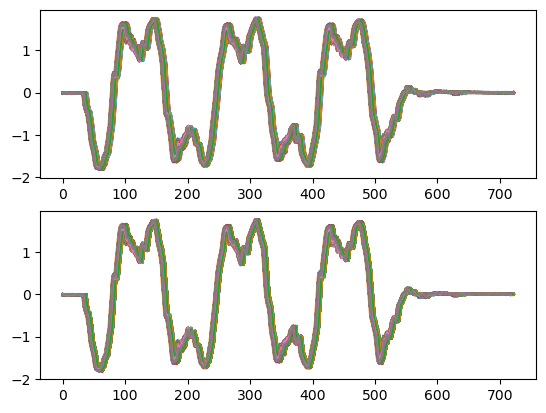

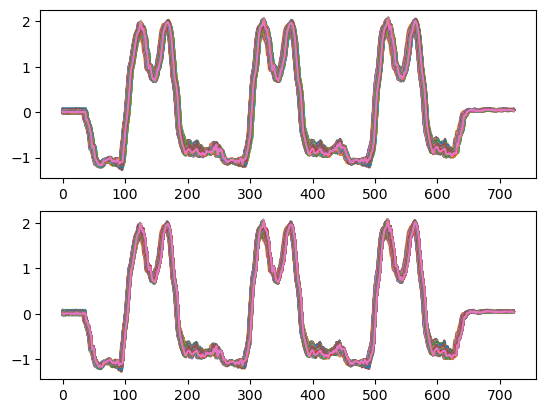

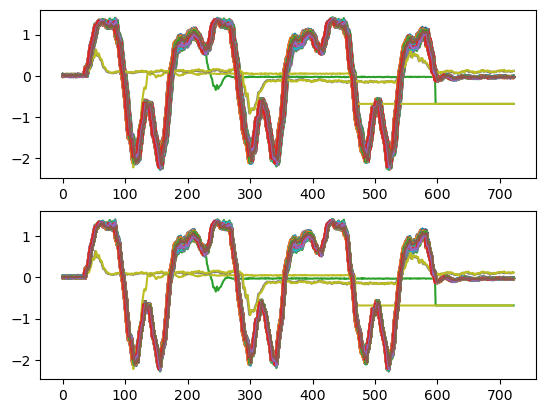

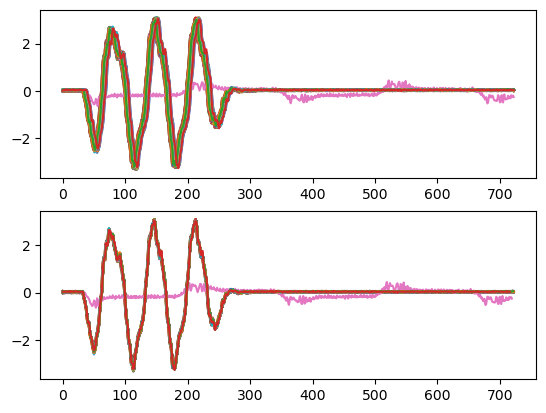

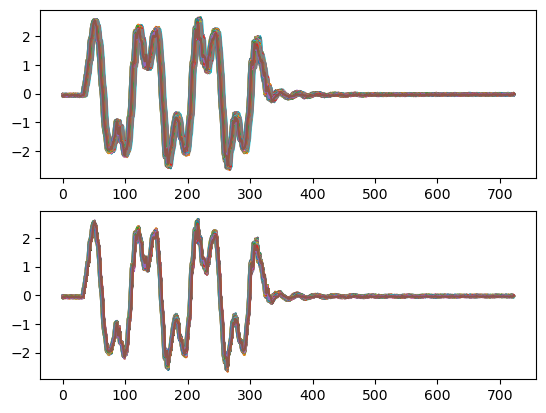

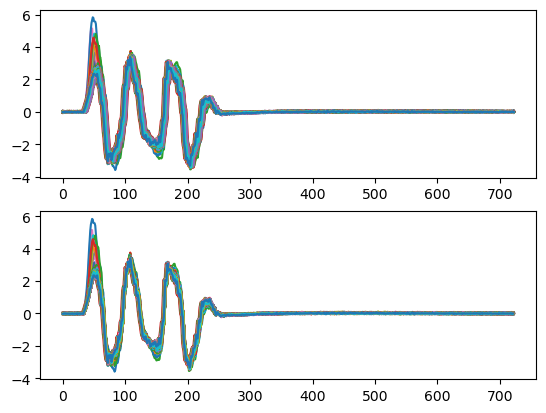

In [86]:
#Failure Case 2
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC2_7142240_66-51134/MCCFiles'
RMS_Value_FC2,Stv_FC2 = generate_feature(File_path)


In [92]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139/04-64139_DIAGDATA_20170918_135452_3ece932f-a030-4c95-bd2c-e6d899ed8871_MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()


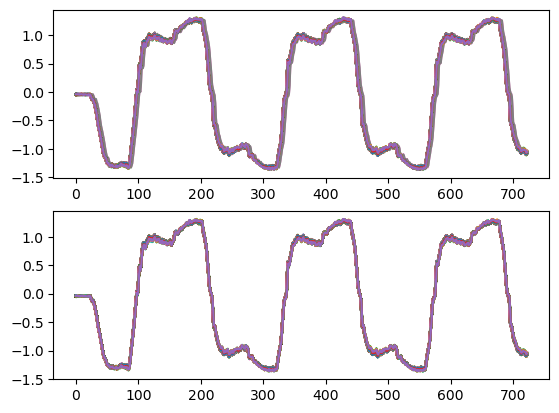

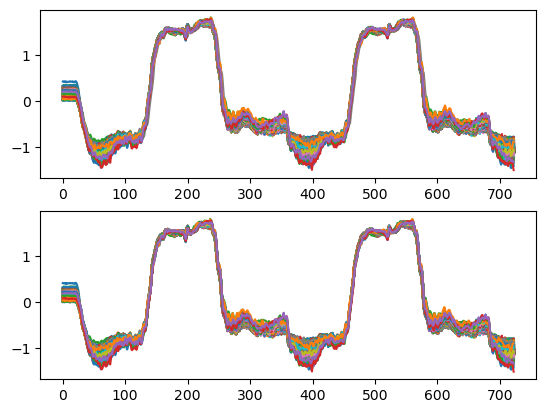

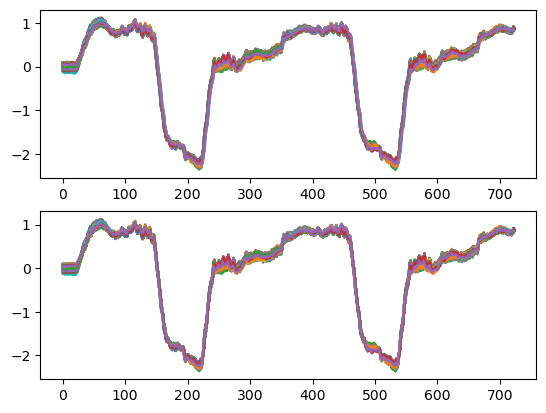

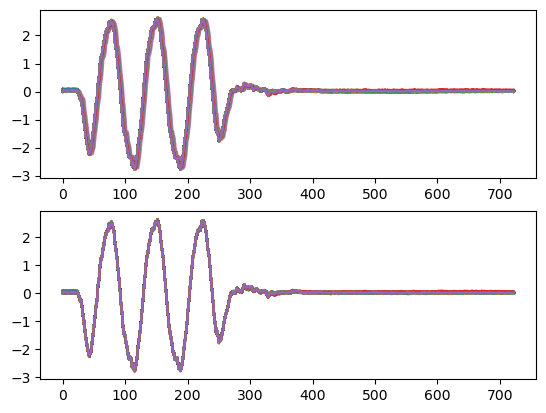

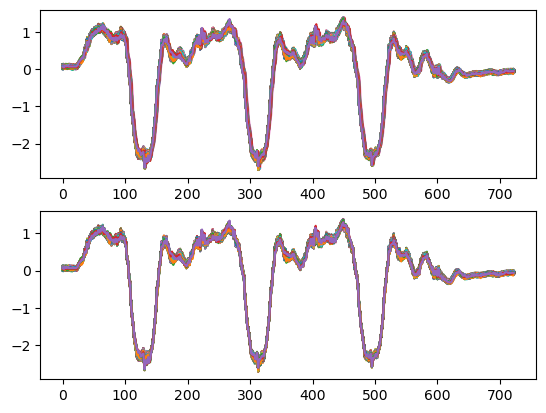

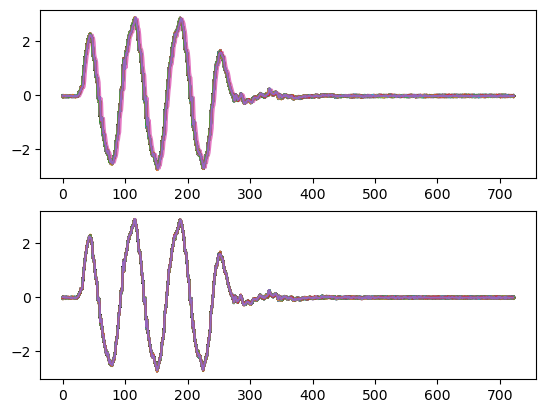

In [95]:
#Failure Case 10
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139/MCC Flies'
RMS_Value_FC10,Stv_FC10 = generate_feature(File_path)

In [224]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC1_113727087_6700-101962/1426-0051-56_DIAGDATA_20151016_090000__MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()

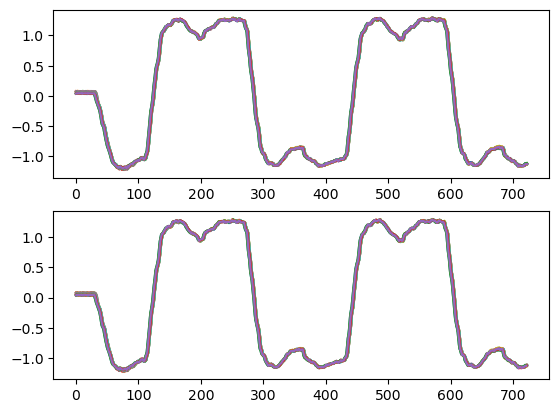

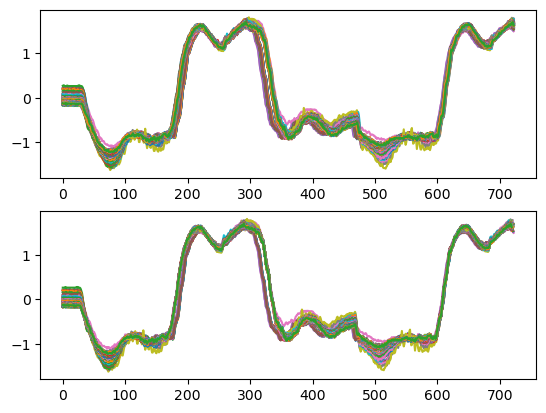

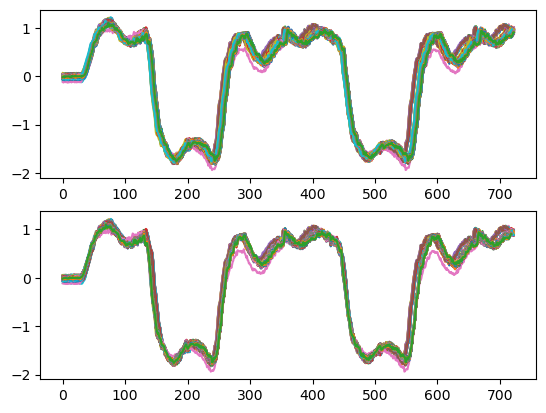

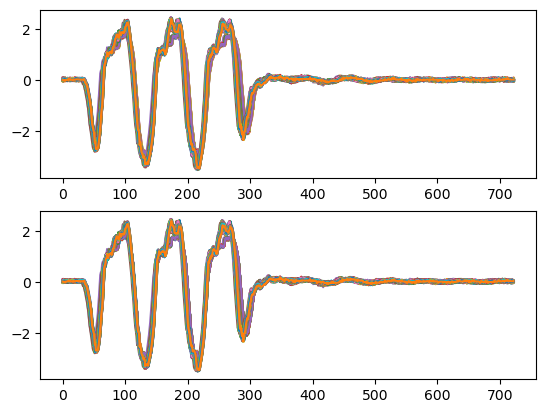

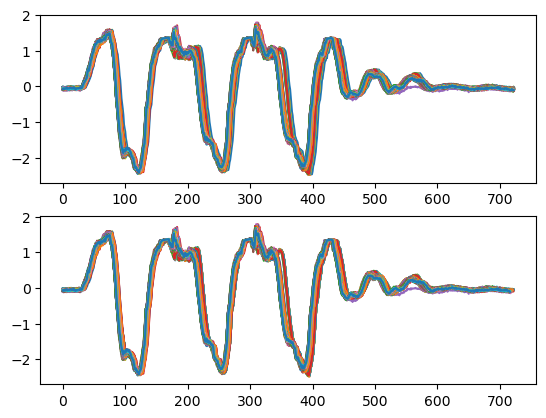

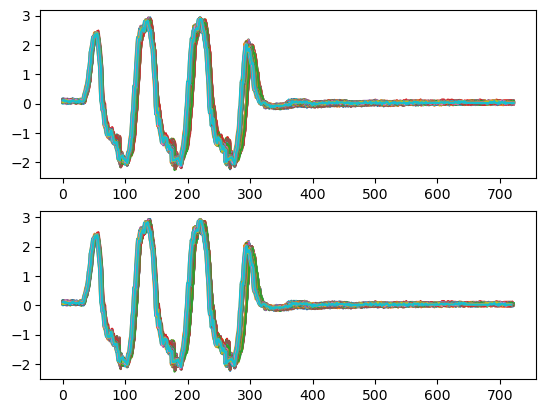

In [225]:
#Failure Case 1
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC1_113727087_6700-101962/MCCFiles'
RMS_Value_FC1,Stv_FC1 = generate_feature(File_path)


In [185]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC3_33958577_46-50029/0824-0007-56_DIAGDATA_20091123_190122_MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()

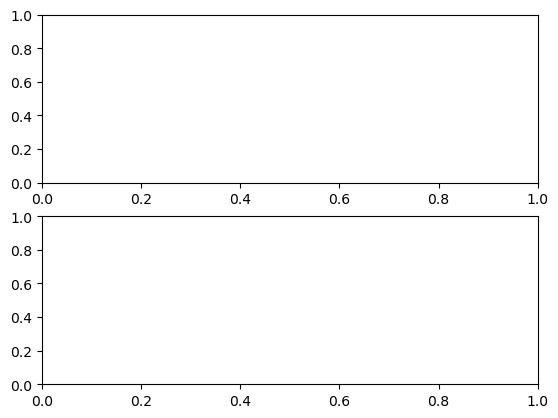

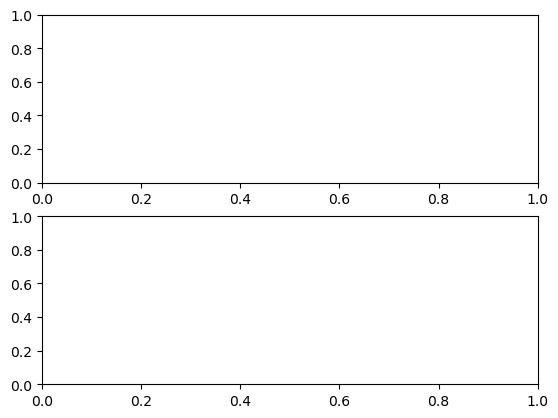

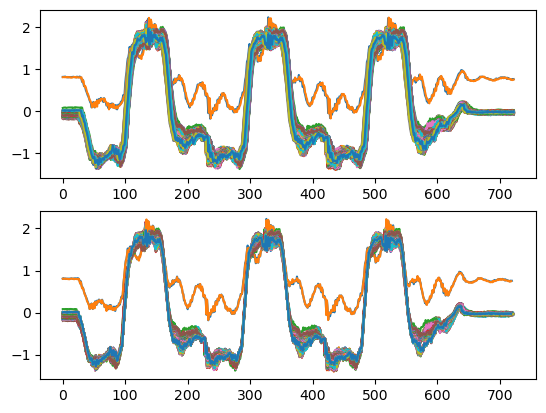

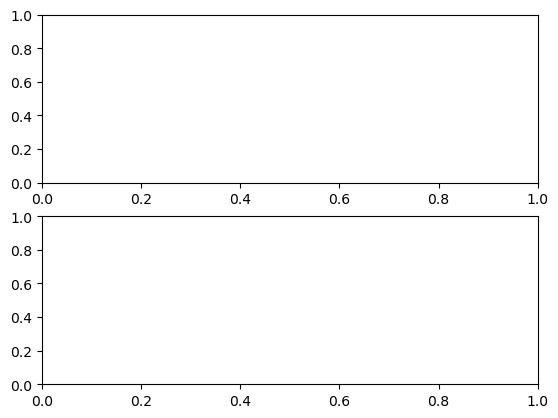

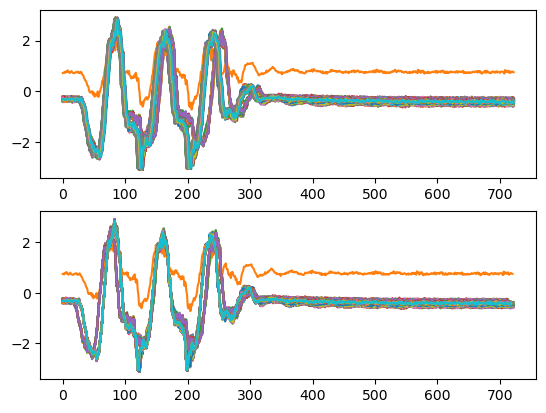

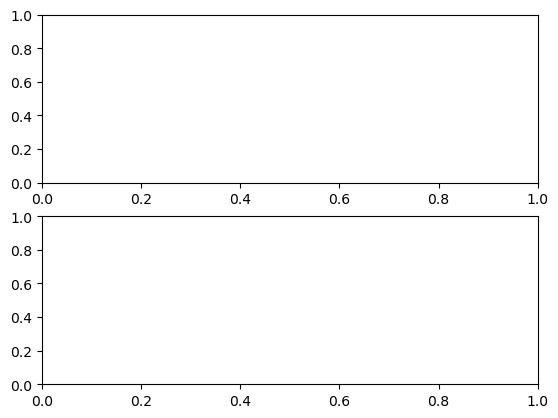

In [186]:
#Failure Case 3
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC3_33958577_46-50029/MCCFiles'
RMS_Value_FC3,Stv_FC3 = generate_feature(File_path)

In [195]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC6_33016615_66-62028/1218-0079-56_DIAGDATA_20150410_142226__MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()


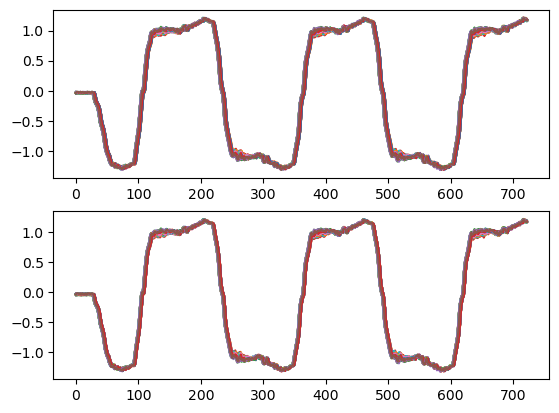

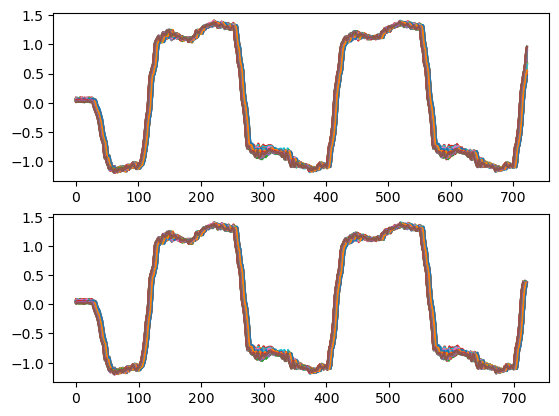

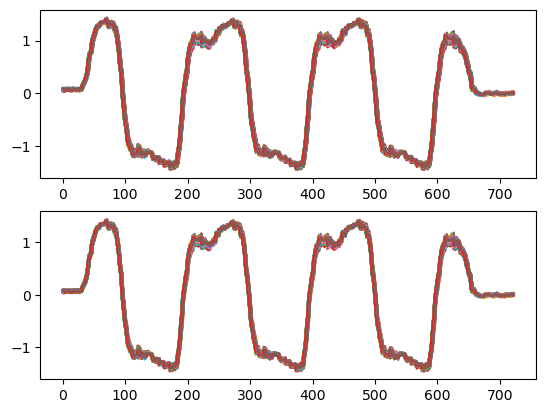

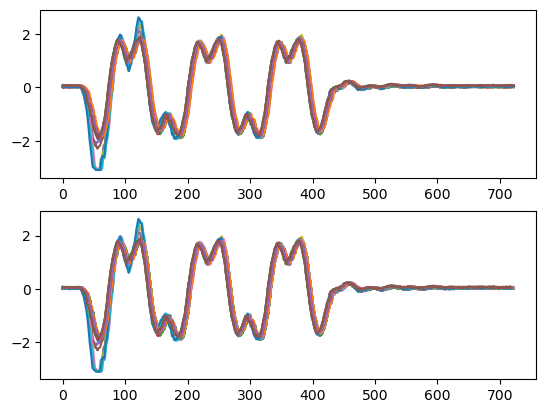

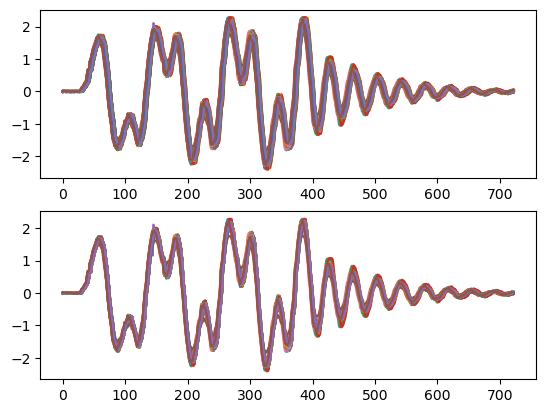

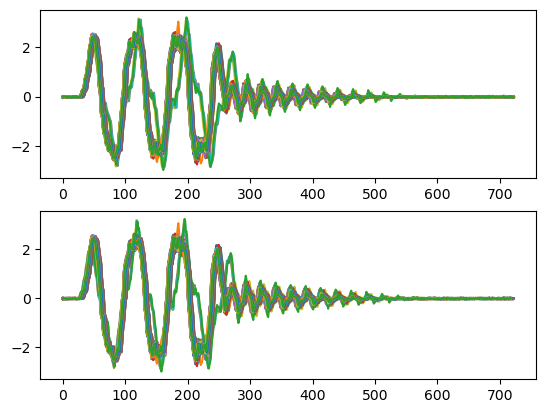

In [196]:
#Failure Case 6
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC6_33016615_66-62028/MCCFiles'
RMS_Value_FC6,Stv_FC6 = generate_feature(File_path)

In [235]:

RMS_Value_FC6 = RMS_Value_FC6.dropna(axis=0,how='any')


axis1     axis2     axis3     axis4     axis5     axis6
40  0.042103  0.012753    0.0165  0.036721  0.097559  0.161302
41  0.039978  0.014085  0.016115  0.040584  0.089885  0.163147
42  0.016081  0.018261  0.026899  0.031891  0.090924  0.152592
43  0.042101   0.01719   0.01606  0.038549  0.094813   0.15865
44  0.040172  0.018241  0.014969  0.038412  0.094881  0.158382
45   0.01321  0.012569  0.022453   0.03396  0.092269  0.150534
46  0.041641  0.023439  0.016648  0.038938  0.090911  0.137281
47  0.040428  0.023701  0.036766  0.028531  0.103956   0.68449
48  0.040425  0.017545  0.029697   0.03543  0.077623   0.12164
49  0.021863   0.01957  0.037993  0.031237  0.095047  0.679359
51  0.046129  0.016525  0.024355  0.028924  0.066685  0.090709
52  0.026548  0.029845  0.036724  0.026381  0.073634  0.240905
53  0.042331  0.017714   0.02557  0.028838  0.097024  0.693611
56  0.039665  0.018882   0.01573  0.249498  0.074327   0.07308
57  0.024195  0.016602  0.040715  0.231496  0.090742  0.081583
58  0.043456  0.014364  0.021471  0.265403   0.08063  0.069165
59  0.043882  0.014896  0.020609  0.302962  0.067363  0.072182
60   0.04022   0.01889  0.024052  0.304726  0.070726  0.090692
61  0.018465  0.015155  0.038628  0.068861  0.076113  0.079924
62  0.046806  0.018641  0.025519  0.068148  0.071373  0.074898

In [240]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC7_130270916_7600-102993/7600-102993_DIAGDATA_20160331_050019__MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()

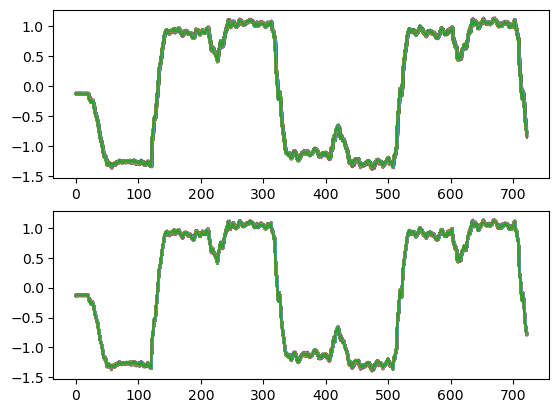

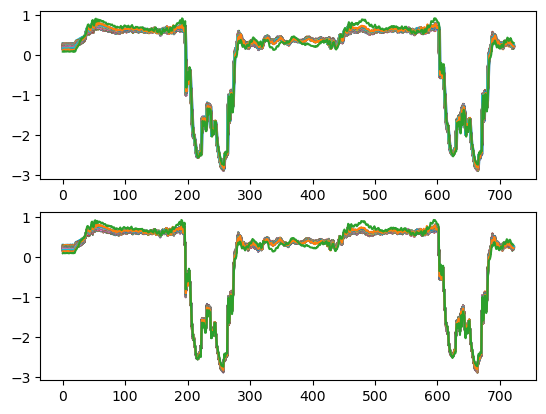

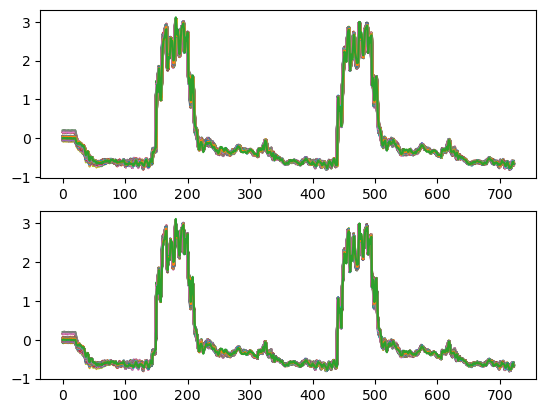

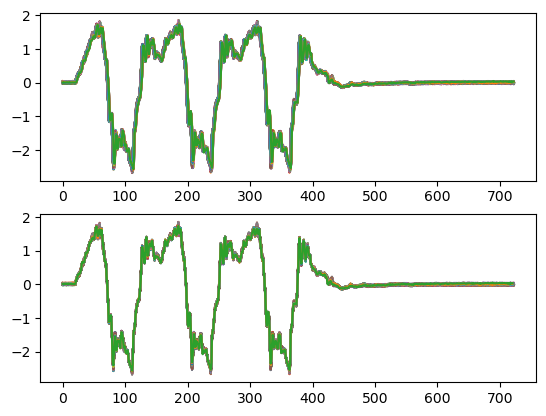

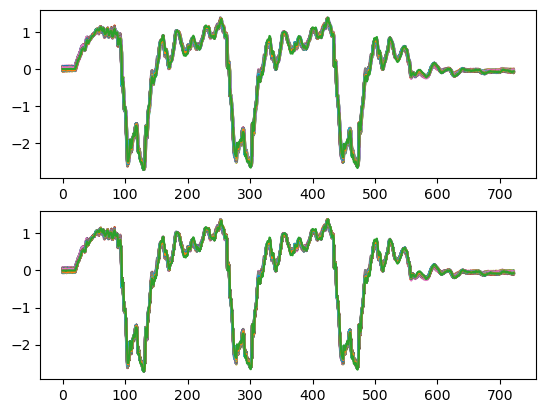

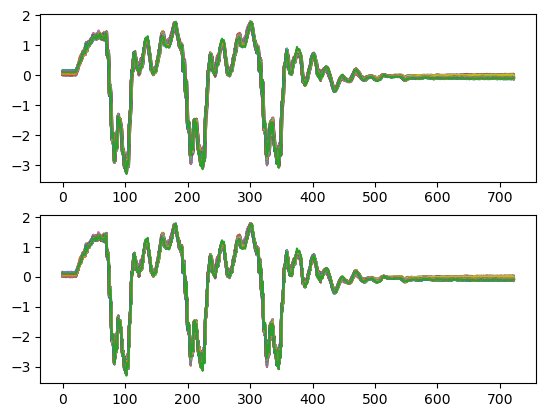

In [241]:
#Failure Case 7
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC7_130270916_7600-102993/MCCFiles'
RMS_Value_FC7,Stv_FC7,Energy_FC7 = generate_feature(File_path)

In [265]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC8_103507723_6700-100888/1237-0041-56_DIAGDATA_20141107_131229_1a2edf8e-8453-4210-8f9d-4bbc65e75273_MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()

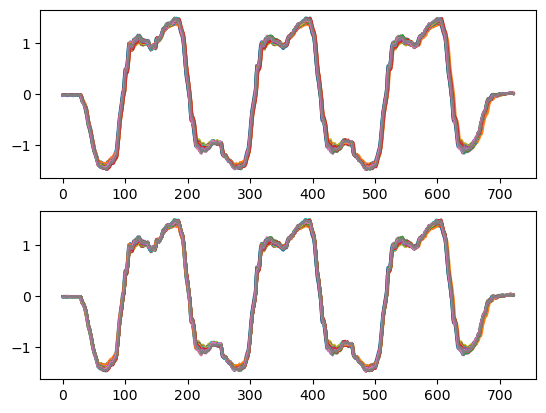

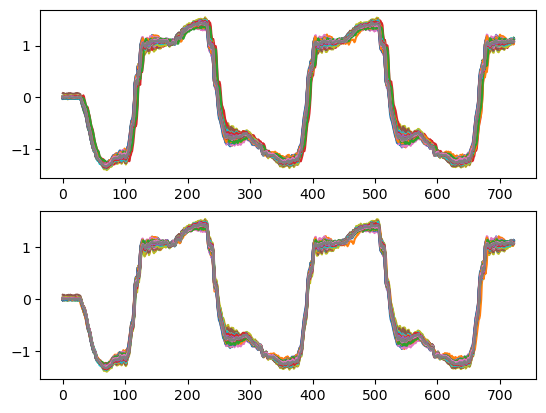

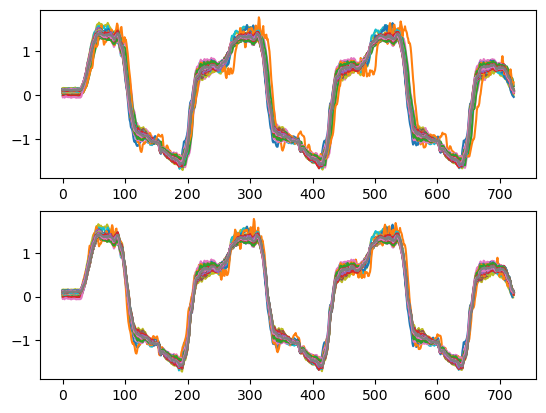

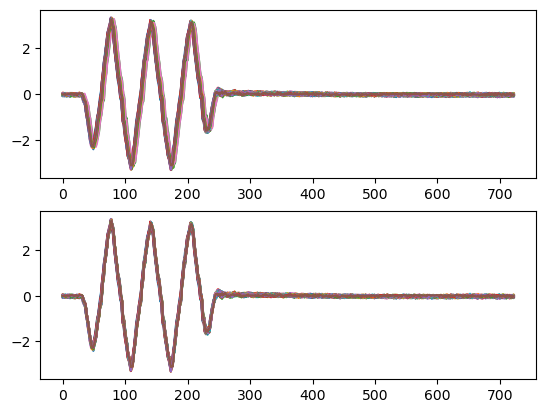

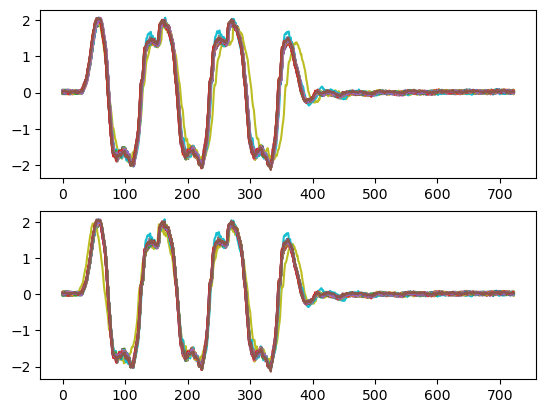

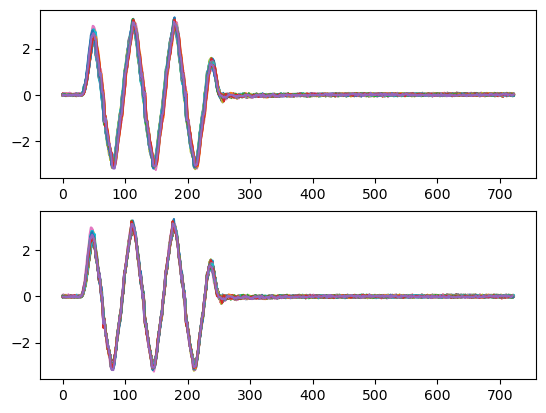

In [266]:
#Failure Case 8
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC8_103507723_6700-100888/MCCFiles'
RMS_Value_FC8,Stv_FC8,Energy_FC8 = generate_feature(File_path)

In [267]:
data_FC8 = Energy_FC8
for index, column in data_FC8.iteritems():
    E_mean = column.mean()
    E_stv = column.std(ddof=0)
    E_max = column.max()
    E_min = column.min()
    for i in range(len(column)):
        data_FC8.loc[i, index] = (data_FC8.loc[i, index] - E_min)/(E_max - E_min)


<AxesSubplot:>

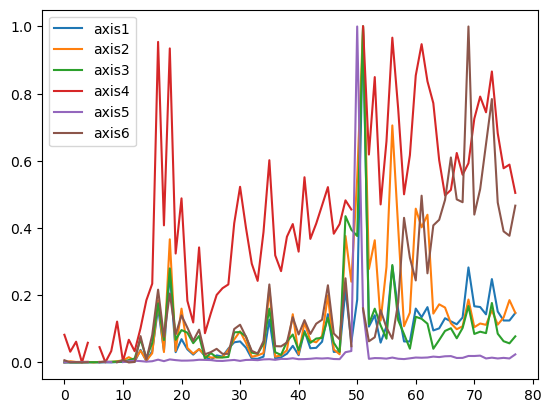

In [268]:
data_FC8.plot()

<AxesSubplot:>

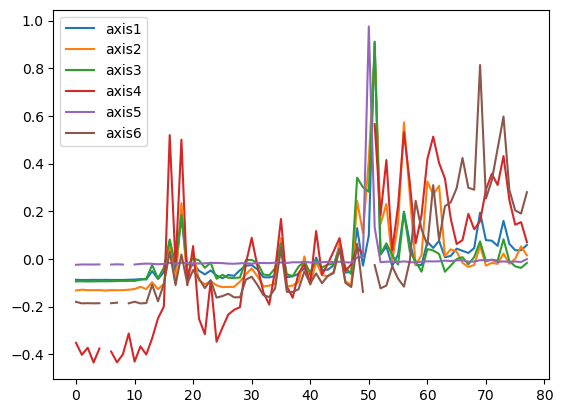

In [263]:
data_FC8.plot()

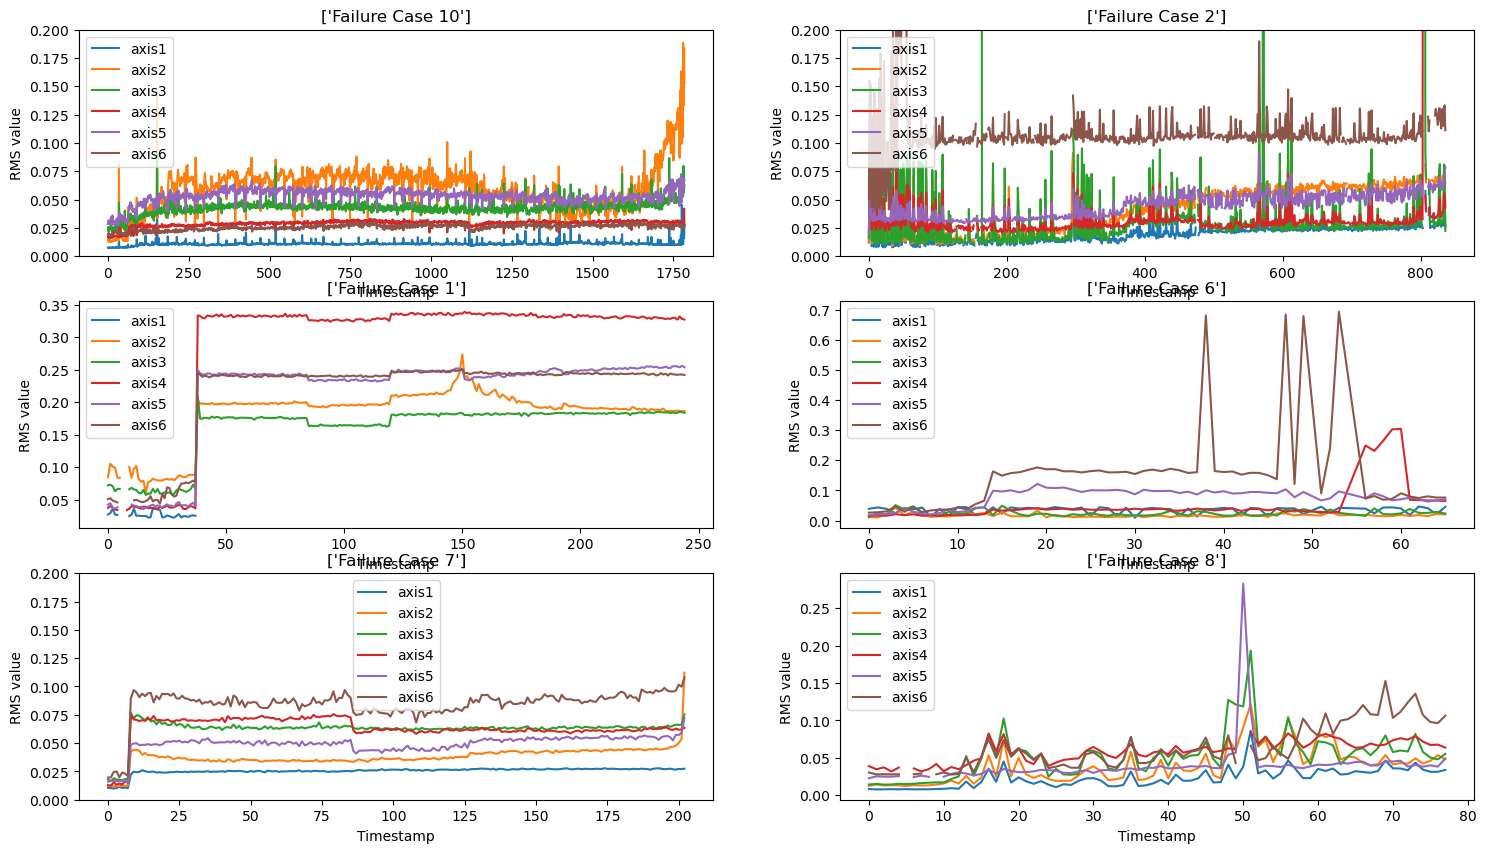

In [244]:
axis_list = ['axis1','axis2','axis3','axis4','axis5','axis6']
fig = plt.figure(figsize=(18,10))  
ax1 = fig.add_subplot(321)  
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)  
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)  
ax6 = fig.add_subplot(326)

for index in axis_list:

    ax1.plot(RMS_Value_FC10[index], label= index)
    ax1.set_title(['Failure Case 10'])  
    ax1.set_xlabel('Timestamp')  
    ax1.set_ylabel('RMS value')
    ax1.set_ylim(0, .2)
    ax1.legend()
    
    ax2.plot(RMS_Value_FC2[index], label= index)
    ax2.set_title(['Failure Case 2'])  
    ax2.set_xlabel('Timestamp')  
    ax2.set_ylabel('RMS value')
    ax2.set_ylim(0, .2)
    ax2.legend()

    
    ax3.plot(RMS_Value_FC1[index], label= index)
    ax3.set_title(['Failure Case 1'])  
    ax3.set_xlabel('Timestamp')  
    ax3.set_ylabel('RMS value')
#     ax3.set_ylim(0, .2)
    ax3.legend()
    
    ax4.plot(RMS_Value_FC6[index], label= index)
    ax4.set_title(['Failure Case 6'])  
    ax4.set_xlabel('Timestamp')  
    ax4.set_ylabel('RMS value')
#     ax4.set_ylim(0, .2)
    ax4.legend() 
    
    
    ax5.plot(RMS_Value_FC7[index], label= index)
    ax5.set_title(['Failure Case 7'])  
    ax5.set_xlabel('Timestamp')  
    ax5.set_ylabel('RMS value')
    ax5.set_ylim(0, .2)
    ax5.legend()
    
    ax6.plot(RMS_Value_FC8[index], label= index)
    ax6.set_title(['Failure Case 8'])  
    ax6.set_xlabel('Timestamp')  
    ax6.set_ylabel('RMS value')
#     ax6.set_ylim(0, .2)
    ax6.legend()

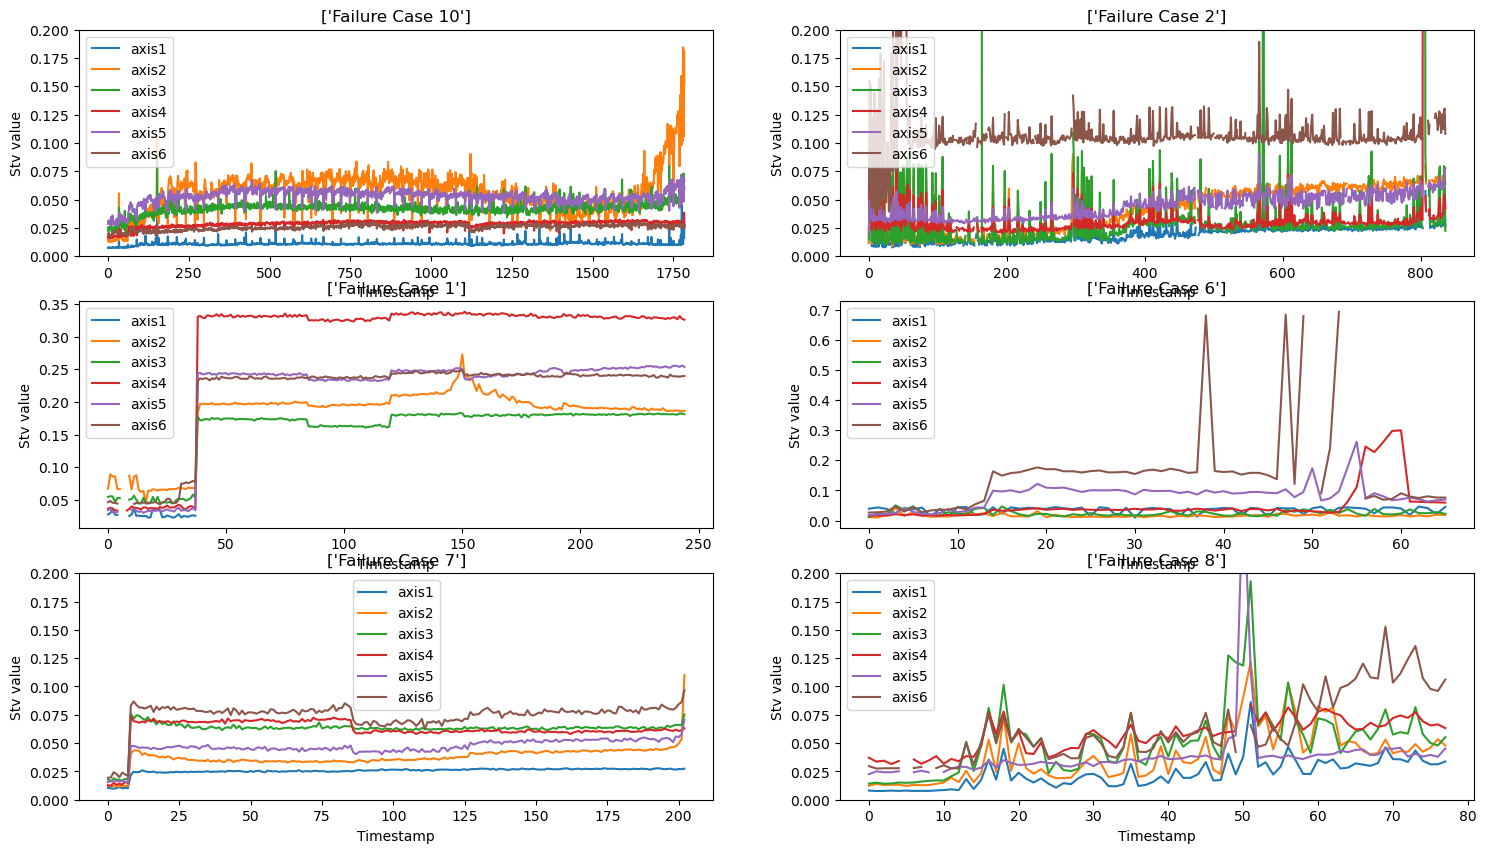

In [222]:
axis_list = ['axis1','axis2','axis3','axis4','axis5','axis6']
fig = plt.figure(figsize=(18,10))  
ax1 = fig.add_subplot(321)  
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)  
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)  
ax6 = fig.add_subplot(326)

for index in axis_list:

    ax1.plot(Stv_FC10[index], label= index)
    ax1.set_title(['Failure Case 10'])  
    ax1.set_xlabel('Timestamp')  
    ax1.set_ylabel('Stv value')
    ax1.set_ylim(0, .2)
    ax1.legend()
    
    ax2.plot(Stv_FC2[index], label= index)
    ax2.set_title(['Failure Case 2'])  
    ax2.set_xlabel('Timestamp')  
    ax2.set_ylabel('Stv value')
    ax2.set_ylim(0, .2)
    ax2.legend()

    
    ax3.plot(Stv_FC1[index], label= index)
    ax3.set_title(['Failure Case 1'])  
    ax3.set_xlabel('Timestamp')  
    ax3.set_ylabel('Stv value')
#     ax3.set_ylim(0, .2)
    ax3.legend()
    
    ax4.plot(Stv_FC6[index], label= index)
    ax4.set_title(['Failure Case 6'])  
    ax4.set_xlabel('Timestamp')  
    ax4.set_ylabel('Stv value')
#     ax4.set_ylim(0, .2)
    ax4.legend() 
    
    
    ax5.plot(Stv_FC7[index], label= index)
    ax5.set_title(['Failure Case 7'])  
    ax5.set_xlabel('Timestamp')  
    ax5.set_ylabel('Stv value')
    ax5.set_ylim(0, .2)
    ax5.legend()
    
    ax6.plot(Stv_FC8[index], label= index)
    ax6.set_title(['Failure Case 8'])  
    ax6.set_xlabel('Timestamp')  
    ax6.set_ylabel('Stv value')
    ax6.set_ylim(0, .2)
    ax6.legend()



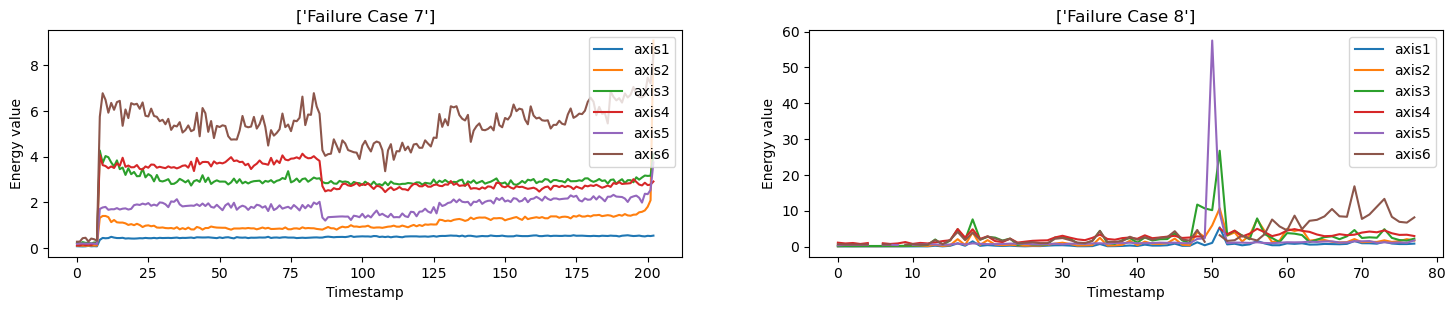

In [248]:
fig = plt.figure(figsize=(18,10))
ax5 = fig.add_subplot(325)  
ax6 = fig.add_subplot(326)
for index in axis_list:

    ax5.plot(Energy_FC7[index], label= index)
    ax5.set_title(['Failure Case 7'])  
    ax5.set_xlabel('Timestamp')  
    ax5.set_ylabel('Energy value')
    
    ax5.legend()
    
    ax6.plot(Energy_FC8[index], label= index)
    ax6.set_title(['Failure Case 8'])  
    ax6.set_xlabel('Timestamp')  
    ax6.set_ylabel('Energy value')

    ax6.legend()


In [247]:
Energy_FC8

axis1     axis2     axis3     axis4     axis5      axis6
0   0.048178  0.111701  0.148203  1.089881  0.370989   0.663581
1   0.042783  0.146949  0.163586  0.869316  0.460254    0.55953
2   0.043678  0.124316  0.144859  0.999638  0.443918   0.570366
3   0.047005  0.127654  0.148593  0.728934  0.442903   0.560152
4   0.044262  0.127775  0.167197  0.985721  0.467428   0.568023
..       ...       ...       ...       ...       ...        ...
73   1.36502  1.750025  4.857764  4.522154  1.189196  13.316697
74  0.850612  1.298813  2.424134  3.716419  1.054002   8.302401
75   0.70828  1.522949  1.828781    3.2607  1.155136   6.907954
76  0.707846   2.07153  1.660138  3.308395  1.052615   6.692656
77  0.826698   1.67103  2.213215   2.93958  1.747679   8.152397

[78 rows x 6 columns]

In [ ]:
axis_list = ['axis1','axis2','axis3','axis4','axis5','axis6']
fig = plt.figure(figsize=(18,10))  
ax1 = fig.add_subplot(321)  
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)  
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)  
ax6 = fig.add_subplot(326)

for index in axis_list:

    ax1.plot(RMS_Value_FC10[index], label= index)
    ax1.set_title(['Failure Case 10'])  
    ax1.set_xlabel('Timestamp')  
    ax1.set_ylabel('RMS value')
    ax1.set_ylim(0, .2)
    ax1.legend()
    
    ax2.plot(RMS_Value_FC2[index], label= index)
    ax2.set_title(['Failure Case 2'])  
    ax2.set_xlabel('Timestamp')  
    ax2.set_ylabel('RMS value')
    ax2.set_ylim(0, .2)
    ax2.legend()

    
    ax3.plot(RMS_Value_FC1[index], label= index)
    ax3.set_title(['Failure Case 1'])  
    ax3.set_xlabel('Timestamp')  
    ax3.set_ylabel('RMS value')
#     ax3.set_ylim(0, .2)
    ax3.legend()
    
    ax4.plot(RMS_Value_FC6[index], label= index)
    ax4.set_title(['Failure Case 6'])  
    ax4.set_xlabel('Timestamp')  
    ax4.set_ylabel('RMS value')
#     ax4.set_ylim(0, .2)
    ax4.legend() 
    
    
    ax5.plot(RMS_Value_FC7[index], label= index)
    ax5.set_title(['Failure Case 7'])  
    ax5.set_xlabel('Timestamp')  
    ax5.set_ylabel('RMS value')
    ax5.set_ylim(0, .2)
    ax5.legend()
    
    ax6.plot(RMS_Value_FC8[index], label= index)
    ax6.set_title(['Failure Case 8'])  
    ax6.set_xlabel('Timestamp')  
    ax6.set_ylabel('RMS value')
#     ax6.set_ylim(0, .2)
    ax6.legend()

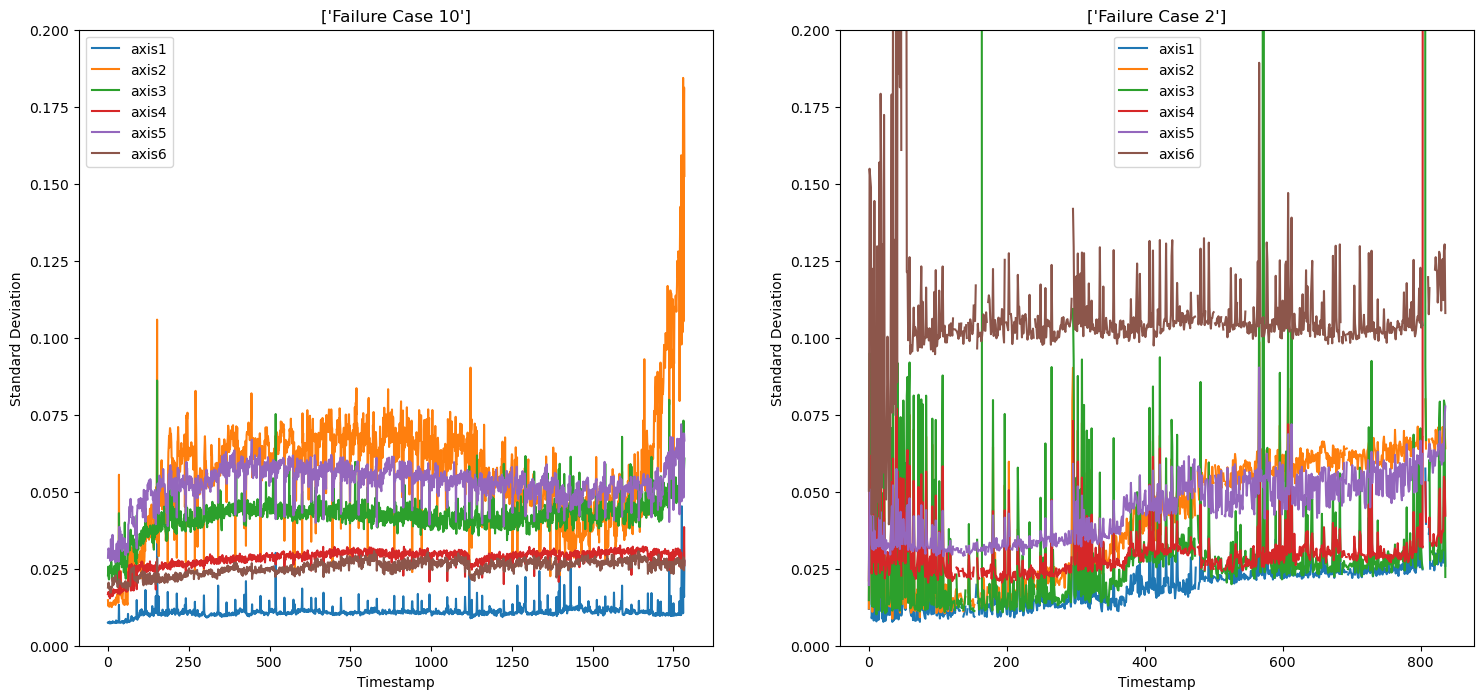

In [127]:
axis_list = ['axis1','axis2','axis3','axis4','axis5','axis6']
fig = plt.figure(figsize=(18,8))  
ax1 = fig.add_subplot(1,2,1)  
ax2 = fig.add_subplot(1,2,2)



for index in axis_list:

    ax1.plot(Stv_FC10[index], label= index)
    ax1.set_title(['Failure Case 10'])  
    ax1.set_xlabel('Timestamp')  
    ax1.set_ylabel('Standard Deviation')
    ax1.set_ylim(0, .2)
    ax1.legend()
    
    ax2.plot(Stv_FC2[index], label= index)
    ax2.set_title(['Failure Case 2'])  
    ax2.set_xlabel('Timestamp')  
    ax2.set_ylabel('Standard Deviation')
    ax2.set_ylim(0, .2)
    ax2.legend()

# Features for each axis

<AxesSubplot:xlabel='timestamp'>

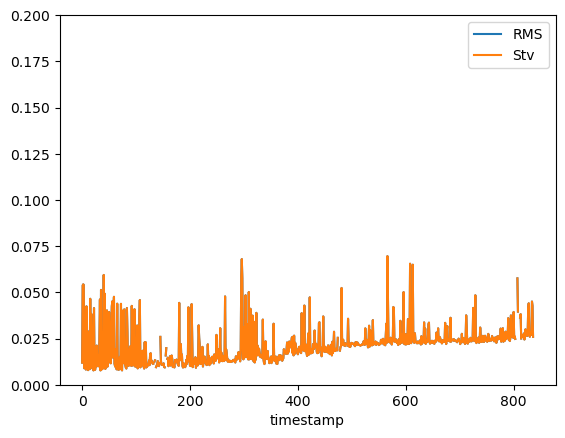

In [129]:
feature_axis1_FC2 = pd.concat([RMS_Value_FC2['axis1'],Stv_FC2['axis1']],axis=1)
feature_axis1_FC2.columns = ['RMS','Stv']

df1_FC2 = feature_axis1_FC2
df1_FC2.plot(xlabel='timestamp',ylim=[0, 0.2])


<AxesSubplot:xlabel='timestamp'>

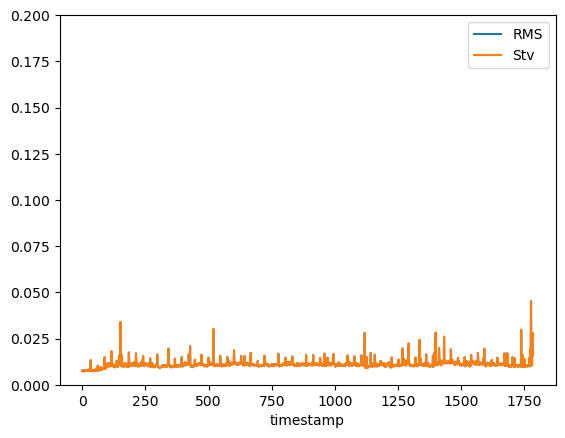

In [130]:
feature_axis1_FC10 = pd.concat([RMS_Value_FC10['axis1'],Stv_FC10['axis1']],axis=1)
feature_axis1_FC10.columns = ['RMS','Stv']


feature_axis1_FC10.plot(xlabel='timestamp',ylim=[0, 0.2])

<AxesSubplot:xlabel='timestamp'>

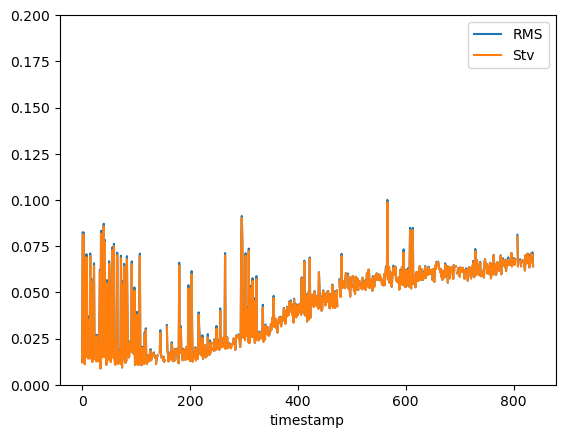

In [150]:
feature_axis2_FC2 = pd.concat([RMS_Value_FC2['axis2'],Stv_FC2['axis2']],axis=1)
feature_axis2_FC2.columns = ['RMS','Stv']

feature_axis2_FC10 = pd.concat([RMS_Value_FC10['axis2'],Stv_FC10['axis2']],axis=1)
feature_axis2_FC10.columns = ['RMS','Stv']

feature_axis2_FC2.plot(xlabel='timestamp',ylim=[0, 0.2])

In [162]:
feature_axis3_FC2 = pd.concat([RMS_Value_FC2['axis3'],Stv_FC2['axis3']],axis=1)
feature_axis3_FC2.columns = ['RMS','Stv']

feature_axis3_FC10 = pd.concat([RMS_Value_FC10['axis3'],Stv_FC10['axis3']],axis=1)
feature_axis3_FC10.columns = ['RMS','Stv']

In [146]:
feature_axis4_FC2 = pd.concat([RMS_Value_FC2['axis4'],Stv_FC2['axis4']],axis=1)
feature_axis4_FC2.columns = ['RMS','Stv']

feature_axis4_FC10 = pd.concat([RMS_Value_FC10['axis4'],Stv_FC10['axis4']],axis=1)
feature_axis4_FC10.columns = ['RMS','Stv']

In [166]:
feature_axis5_FC2 = pd.concat([RMS_Value_FC2['axis5'],Stv_FC2['axis5']],axis=1)
feature_axis5_FC2.columns = ['RMS','Stv']

feature_axis5_FC10 = pd.concat([RMS_Value_FC10['axis5'],Stv_FC10['axis5']],axis=1)
feature_axis5_FC10.columns = ['RMS','Stv']

In [147]:
feature_axis6_FC2 = pd.concat([RMS_Value_FC2['axis6'],Stv_FC2['axis6']],axis=1)
feature_axis6_FC2.columns = ['RMS','Stv']

feature_axis6_FC10 = pd.concat([RMS_Value_FC10['axis6'],Stv_FC10['axis6']],axis=1)
feature_axis6_FC10.columns = ['RMS','Stv']

# Clustering between two features (each axis) 

In [153]:
from sklearn.cluster import KMeans

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, "['Failure Case 10-axis1']")

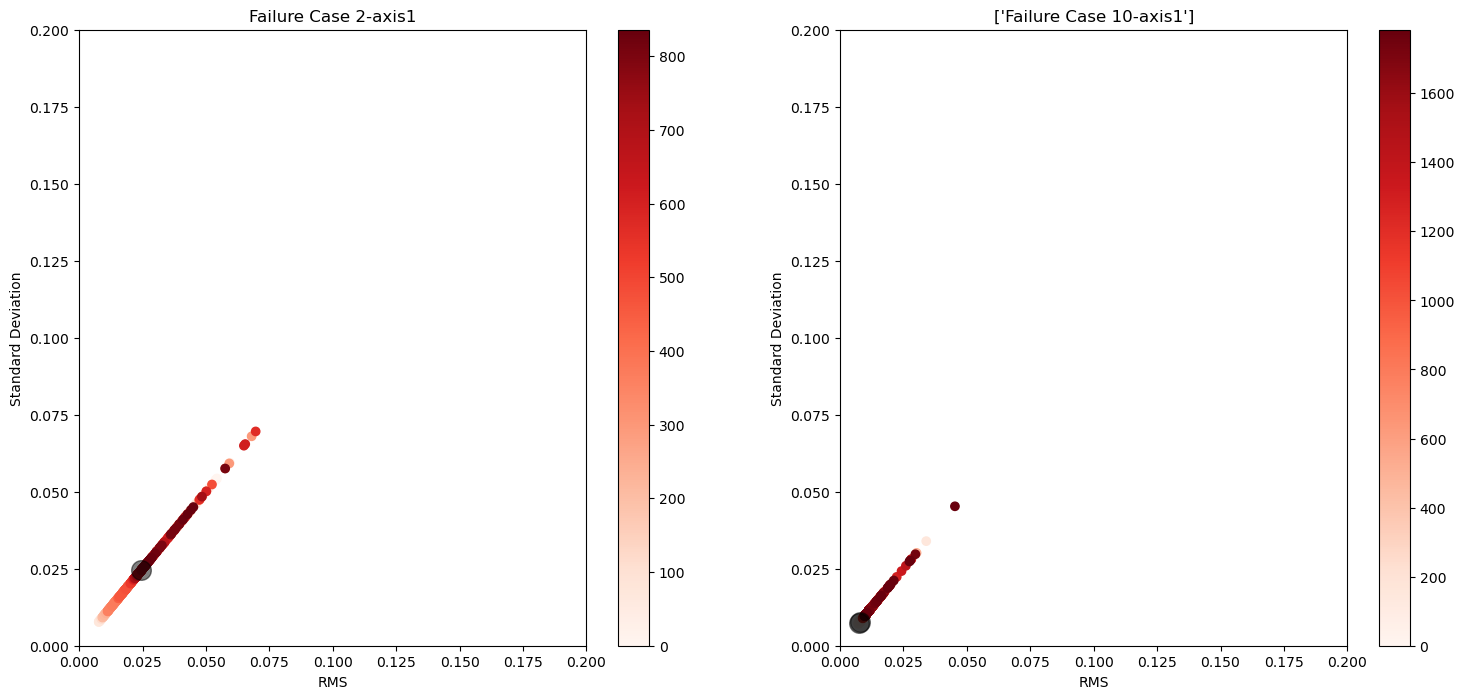

In [158]:
fig = plt.figure(figsize=(18,8))  
ax1 = fig.add_subplot(1,2,1)  
ax2 = fig.add_subplot(1,2,2)
ax1.set_ylim(0, .2)
ax1.set_xlim(0, .2)
ax2.set_ylim(0, .2)
ax2.set_xlim(0, .2)
 
ax2.set_xlabel('RMS')  
ax2.set_ylabel('Standard Deviation')

ax1.set_xlabel('RMS')  
ax1.set_ylabel('Standard Deviation')

data1 = feature_axis1_FC2
data2 = feature_axis1_FC10
FCname1, FCname2 = 'Failure Case 2-axis1','Failure Case 10-axis1'

p_cluster1 = data1[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster1)

index = np.arange(len(data1))
# p_cluster.shape
sc = ax1.scatter(data1['RMS'], data1['Stv'],c= index, cmap='Reds')

plt.colorbar(sc, ax=ax1)
centers1 = kmeans.cluster_centers_
ax1.scatter(centers1[:, 0], centers1[:, 1], c='black', s=200, alpha=0.5);
ax1.set_title(FCname1)  



p_cluster2 = data2[0:20]
kmeans = KMeans(n_clusters=2)
kmeans.fit(p_cluster2)

index = np.arange(len(data2))
# p_cluster.shape
sc = ax2.scatter(data2['RMS'], data2['Stv'],c= index, cmap='Reds')

plt.colorbar(sc, ax=ax2)
centers2 = kmeans.cluster_centers_
ax2.scatter(centers2[:, 0], centers2[:, 1], c='black', s=200, alpha=0.5);
ax2.set_title([FCname2]) 



C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, "['Failure Case 10-axis2']")

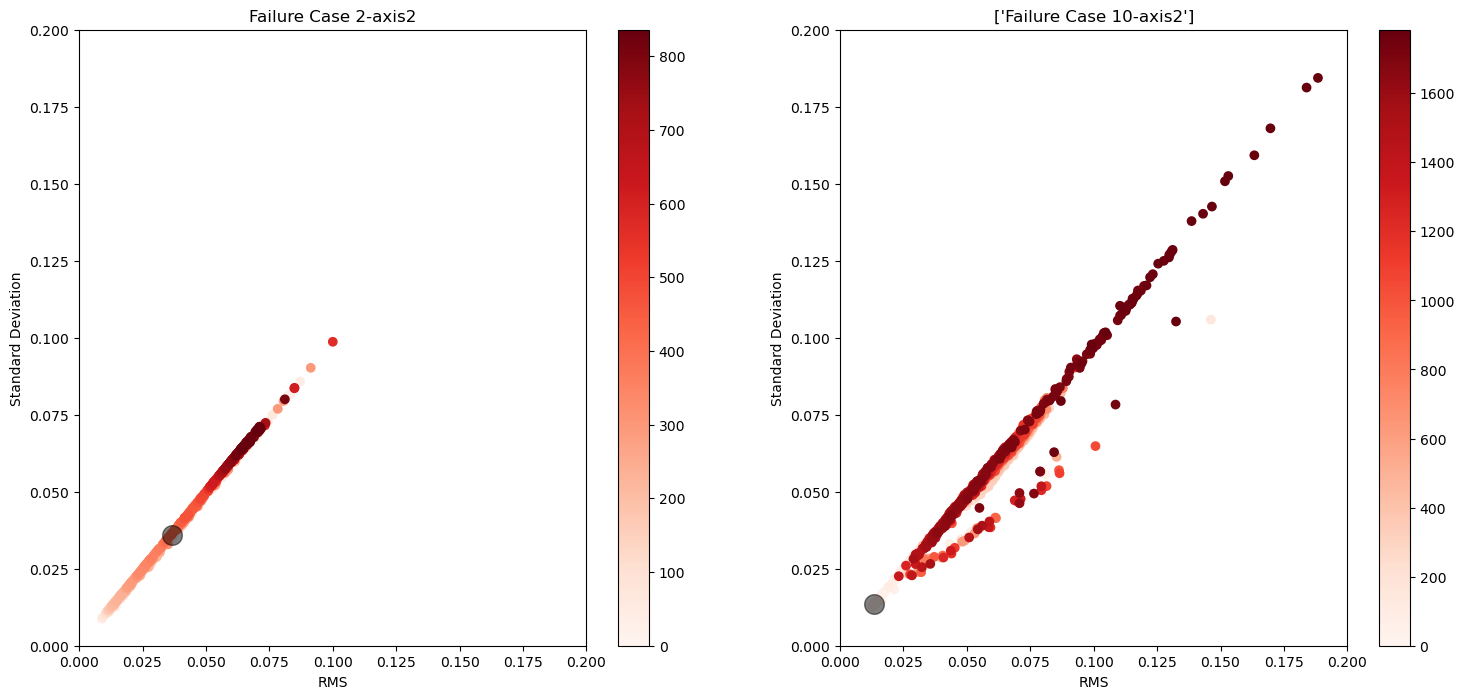

In [169]:
fig = plt.figure(figsize=(18,8))  
ax1 = fig.add_subplot(1,2,1)  
ax2 = fig.add_subplot(1,2,2)
ax1.set_ylim(0, .2)
ax1.set_xlim(0, .2)
ax2.set_ylim(0, .2)
ax2.set_xlim(0, .2)
 
ax2.set_xlabel('RMS')  
ax2.set_ylabel('Standard Deviation')

ax1.set_xlabel('RMS')  
ax1.set_ylabel('Standard Deviation')
data1 = feature_axis2_FC2
data2 = feature_axis2_FC10
FCname1, FCname2 = 'Failure Case 2-axis2','Failure Case 10-axis2'

p_cluster1 = data1[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster1)

index = np.arange(len(data1))
# p_cluster.shape
sc = ax1.scatter(data1['RMS'], data1['Stv'],c= index, cmap='Reds')

plt.colorbar(sc, ax=ax1)
centers1 = kmeans.cluster_centers_
ax1.scatter(centers1[:, 0], centers1[:, 1], c='black', s=200, alpha=0.5);
ax1.set_title(FCname1)  



p_cluster2 = data2[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster2)

index = np.arange(len(data2))
# p_cluster.shape
sc = ax2.scatter(data2['RMS'], data2['Stv'],c= index, cmap='Reds')

plt.colorbar(sc, ax=ax2)
centers2 = kmeans.cluster_centers_
ax2.scatter(centers2[:, 0], centers2[:, 1], c='black', s=200, alpha=0.5);
ax2.set_title([FCname2]) 


C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, "['Failure Case 10-axis3']")

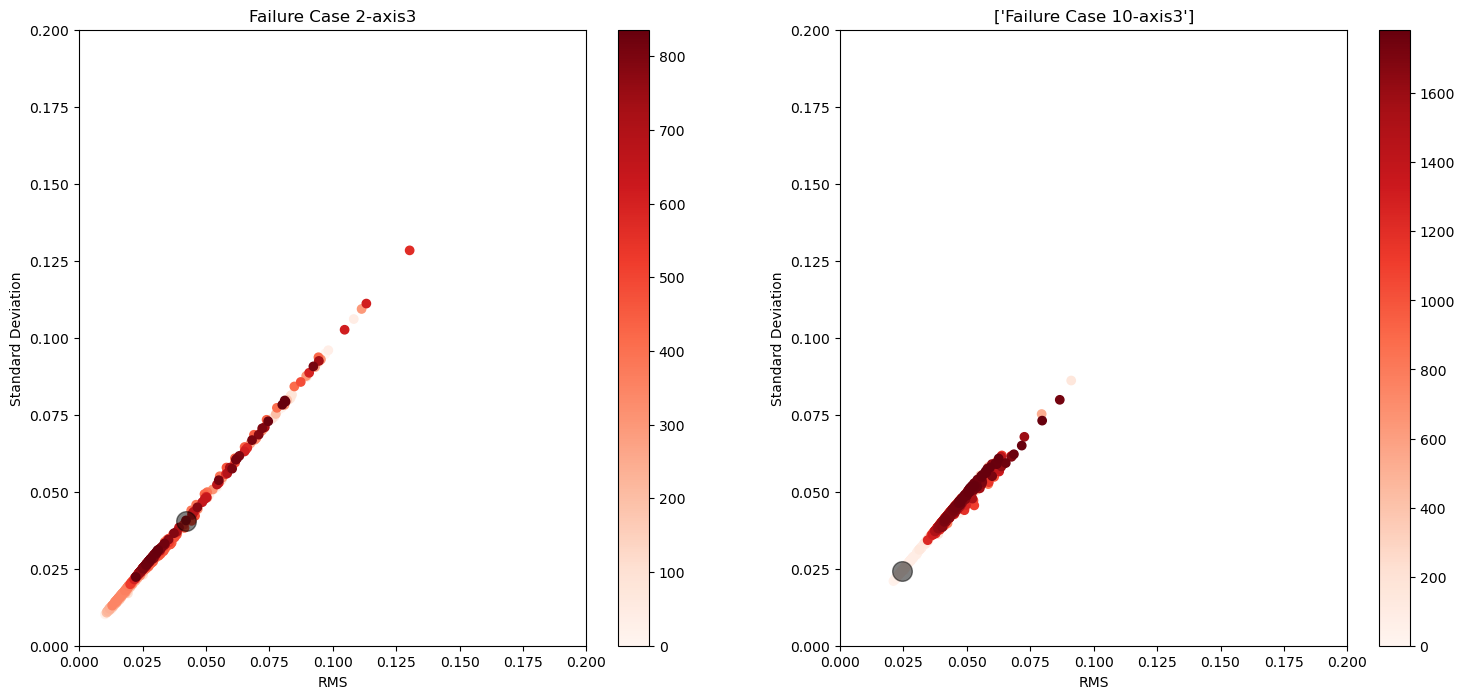

In [170]:
fig = plt.figure(figsize=(18,8))  
ax1 = fig.add_subplot(1,2,1)  
ax2 = fig.add_subplot(1,2,2)
ax1.set_ylim(0, .2)
ax1.set_xlim(0, .2)
ax2.set_ylim(0, .2)
ax2.set_xlim(0, .2)
 
ax2.set_xlabel('RMS')  
ax2.set_ylabel('Standard Deviation')

ax1.set_xlabel('RMS')  
ax1.set_ylabel('Standard Deviation')
data1 = feature_axis3_FC2
data2 = feature_axis3_FC10
FCname1, FCname2 = 'Failure Case 2-axis3','Failure Case 10-axis3'

p_cluster1 = data1[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster1)

index = np.arange(len(data1))
# p_cluster.shape
sc = ax1.scatter(data1['RMS'], data1['Stv'],c= index, cmap='Reds')

plt.colorbar(sc, ax=ax1)
centers1 = kmeans.cluster_centers_
ax1.scatter(centers1[:, 0], centers1[:, 1], c='black', s=200, alpha=0.5);
ax1.set_title(FCname1)  



p_cluster2 = data2[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster2)

index = np.arange(len(data2))
# p_cluster.shape
sc = ax2.scatter(data2['RMS'], data2['Stv'],c= index, cmap='Reds')

plt.colorbar(sc, ax=ax2)
centers2 = kmeans.cluster_centers_
ax2.scatter(centers2[:, 0], centers2[:, 1], c='black', s=200, alpha=0.5);
ax2.set_title([FCname2]) 

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, "['Failure Case 10-axis4']")

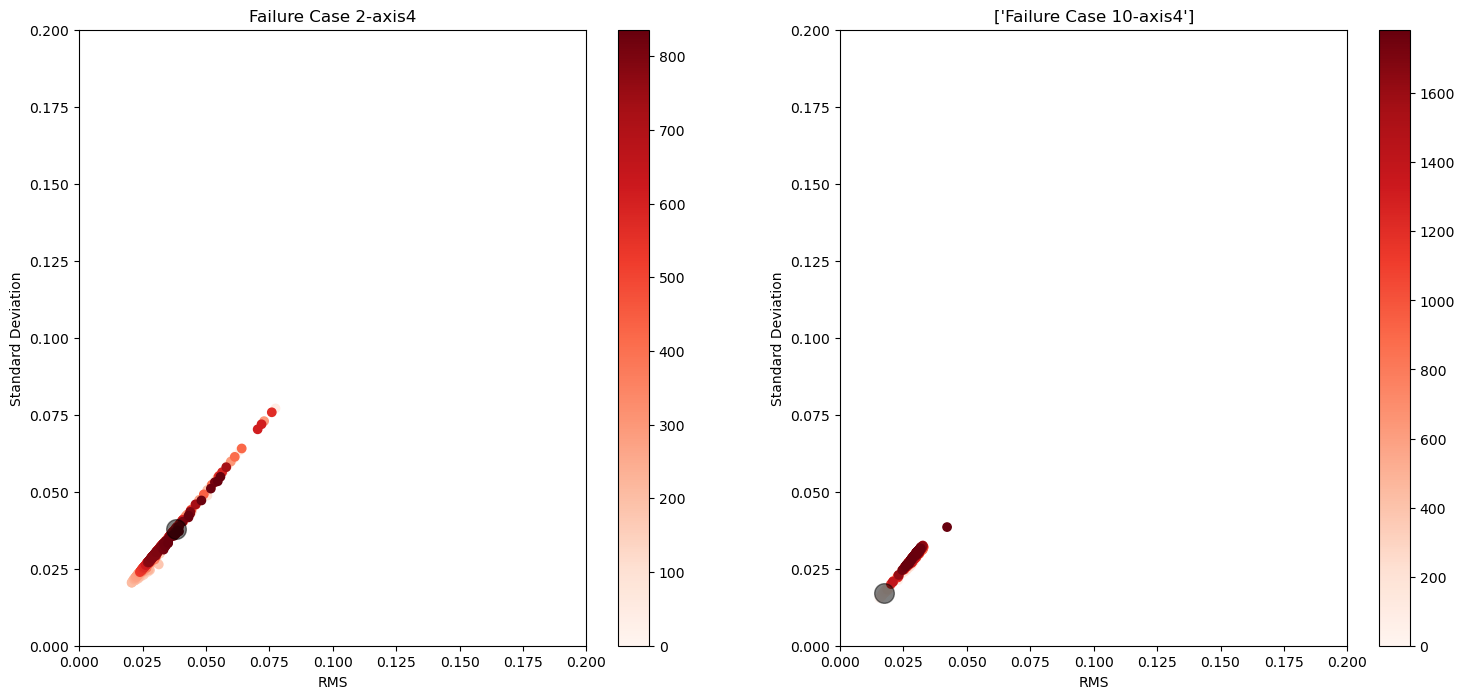

In [171]:
fig = plt.figure(figsize=(18,8))  
ax1 = fig.add_subplot(1,2,1)  
ax2 = fig.add_subplot(1,2,2)
ax1.set_ylim(0, .2)
ax1.set_xlim(0, .2)
ax2.set_ylim(0, .2)
ax2.set_xlim(0, .2)
 
ax2.set_xlabel('RMS')  
ax2.set_ylabel('Standard Deviation')

ax1.set_xlabel('RMS')  
ax1.set_ylabel('Standard Deviation')
data1 = feature_axis4_FC2
data2 = feature_axis4_FC10
FCname1, FCname2 = 'Failure Case 2-axis4','Failure Case 10-axis4'

p_cluster1 = data1[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster1)

index = np.arange(len(data1))
# p_cluster.shape
sc = ax1.scatter(data1['RMS'], data1['Stv'],c= index, cmap='Reds')

plt.colorbar(sc, ax=ax1)
centers1 = kmeans.cluster_centers_
ax1.scatter(centers1[:, 0], centers1[:, 1], c='black', s=200, alpha=0.5);
ax1.set_title(FCname1)  



p_cluster2 = data2[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster2)

index = np.arange(len(data2))
# p_cluster.shape
sc = ax2.scatter(data2['RMS'], data2['Stv'],c= index, cmap='Reds')

plt.colorbar(sc, ax=ax2)
centers2 = kmeans.cluster_centers_
ax2.scatter(centers2[:, 0], centers2[:, 1], c='black', s=200, alpha=0.5);
ax2.set_title([FCname2]) 

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, "['Failure Case 10-axis5']")

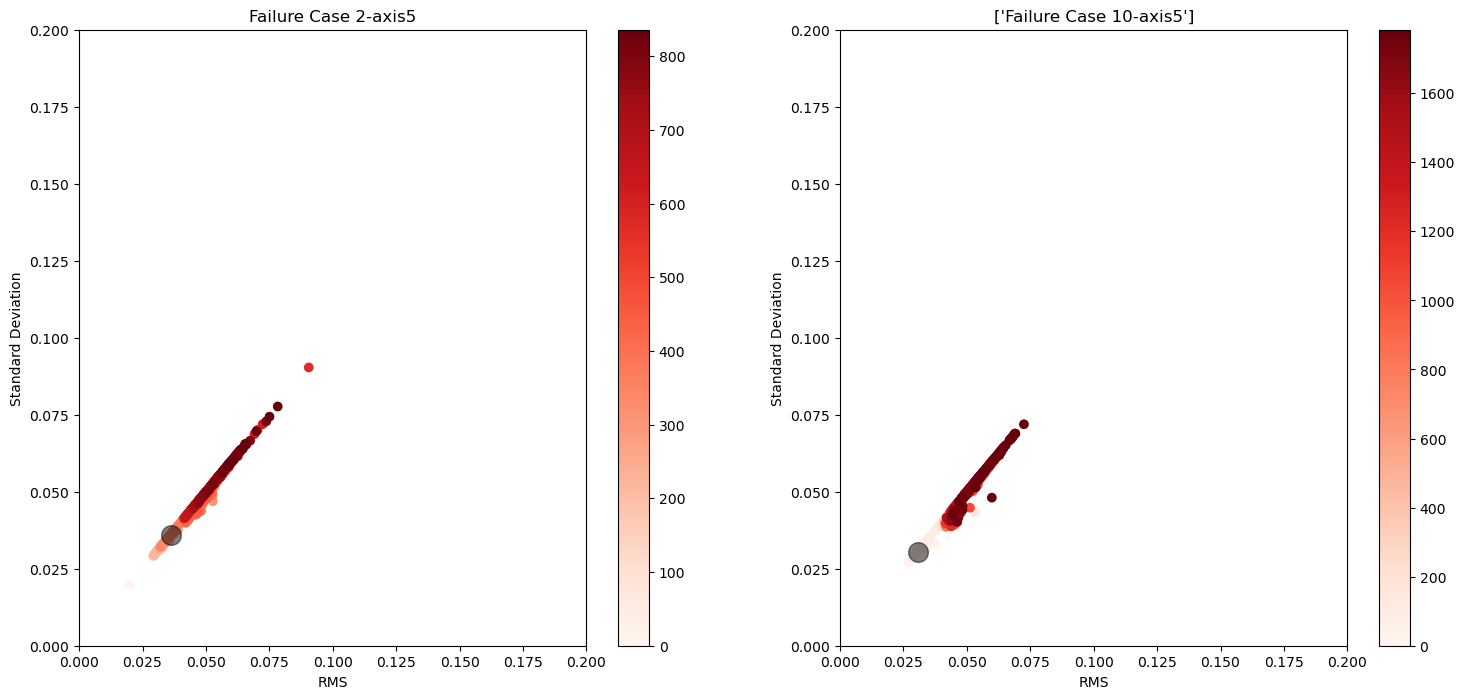

In [172]:
fig = plt.figure(figsize=(18,8))  
ax1 = fig.add_subplot(1,2,1)  
ax2 = fig.add_subplot(1,2,2)
ax1.set_ylim(0, .2)
ax1.set_xlim(0, .2)
ax2.set_ylim(0, .2)
ax2.set_xlim(0, .2)
 
ax2.set_xlabel('RMS')  
ax2.set_ylabel('Standard Deviation')

ax1.set_xlabel('RMS')  
ax1.set_ylabel('Standard Deviation')
data1 = feature_axis5_FC2
data2 = feature_axis5_FC10
FCname1, FCname2 = 'Failure Case 2-axis5','Failure Case 10-axis5'

p_cluster1 = data1[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster1)

index = np.arange(len(data1))
# p_cluster.shape
sc = ax1.scatter(data1['RMS'], data1['Stv'],c= index, cmap='Reds')

plt.colorbar(sc, ax=ax1)
centers1 = kmeans.cluster_centers_
ax1.scatter(centers1[:, 0], centers1[:, 1], c='black', s=200, alpha=0.5);
ax1.set_title(FCname1)  



p_cluster2 = data2[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster2)

index = np.arange(len(data2))
# p_cluster.shape
sc = ax2.scatter(data2['RMS'], data2['Stv'],c= index, cmap='Reds')

plt.colorbar(sc, ax=ax2)
centers2 = kmeans.cluster_centers_
ax2.scatter(centers2[:, 0], centers2[:, 1], c='black', s=200, alpha=0.5);
ax2.set_title([FCname2]) 

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, "['Failure Case 10-axis6']")

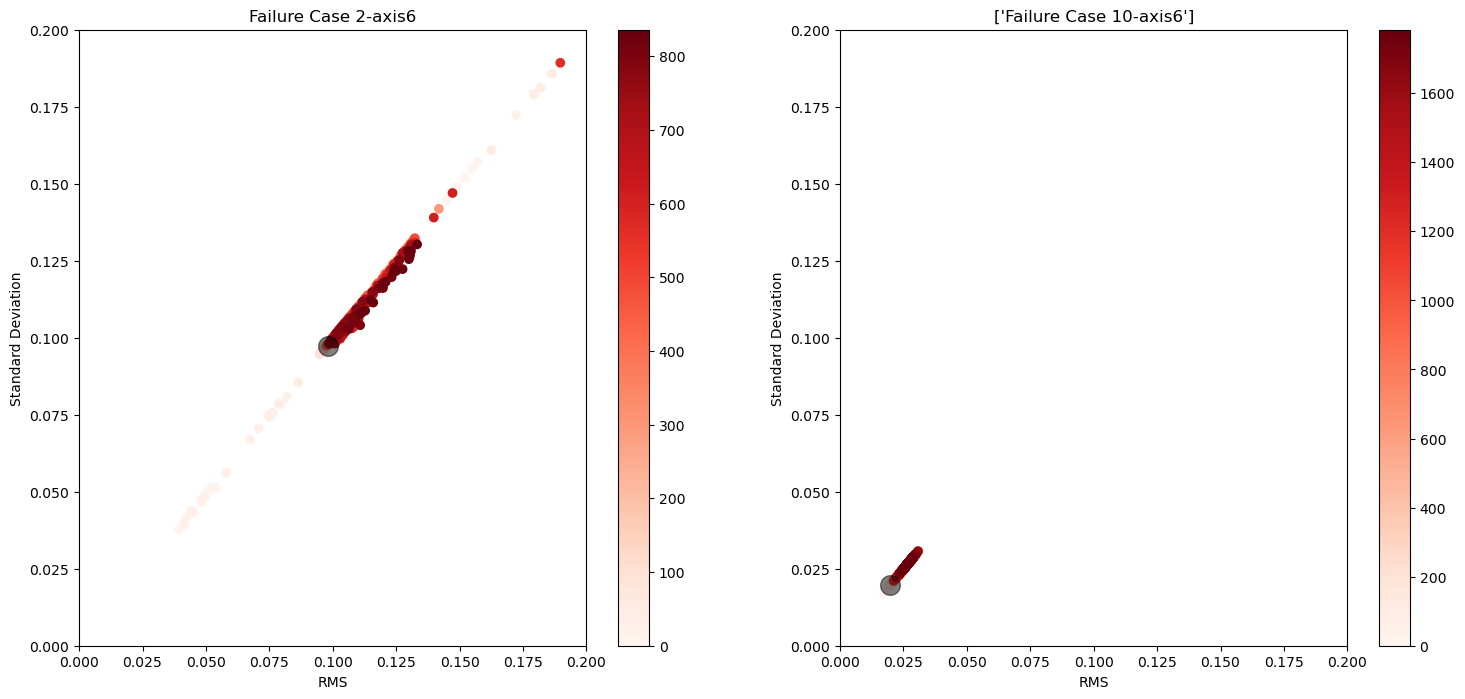

In [173]:
fig = plt.figure(figsize=(18,8))  
ax1 = fig.add_subplot(1,2,1)  
ax2 = fig.add_subplot(1,2,2)
ax1.set_ylim(0, .2)
ax1.set_xlim(0, .2)
ax2.set_ylim(0, .2)
ax2.set_xlim(0, .2)
 
ax2.set_xlabel('RMS')  
ax2.set_ylabel('Standard Deviation')

ax1.set_xlabel('RMS')  
ax1.set_ylabel('Standard Deviation')
data1 = feature_axis6_FC2
data2 = feature_axis6_FC10
FCname1, FCname2 = 'Failure Case 2-axis6','Failure Case 10-axis6'

p_cluster1 = data1[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster1)

index = np.arange(len(data1))
# p_cluster.shape
sc = ax1.scatter(data1['RMS'], data1['Stv'],c= index, cmap='Reds')

plt.colorbar(sc, ax=ax1)
centers1 = kmeans.cluster_centers_
ax1.scatter(centers1[:, 0], centers1[:, 1], c='black', s=200, alpha=0.5);
ax1.set_title(FCname1)  



p_cluster2 = data2[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster2)

index = np.arange(len(data2))
# p_cluster.shape
sc = ax2.scatter(data2['RMS'], data2['Stv'],c= index, cmap='Reds')

plt.colorbar(sc, ax=ax2)
centers2 = kmeans.cluster_centers_
ax2.scatter(centers2[:, 0], centers2[:, 1], c='black', s=200, alpha=0.5);
ax2.set_title([FCname2]) 

# Euclidean distance between the centroid of reference cluster and the new points

(0.0, 0.3)

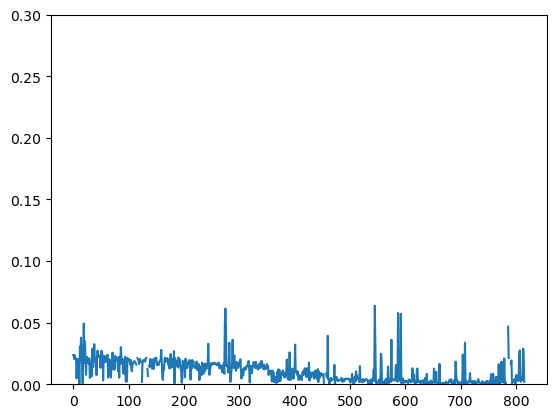

In [46]:

Distance = []
for i in range(21, len(data1)):
    x = data1.iloc[i].to_numpy() 
    dist = (np.linalg.norm(x-centers1))
    Distance.append(dist)
    
plt.plot(Distance)    

plt.ylim(0, .3)

In [ ]:
kmeans = KMeans(n_clusters=1)

# Initiate the reference cluster
ref_cluster = data1[0:20]
ref_array = ref_cluster.to_numpy() 
#Find the centroid of this cluster
reference1 = kmeans.fit(ref_cluster)
centers1 = reference.cluster_centers_
print('centroid of the reference cluster is',centers1)
# Initiate the number N
num = 0
# Create an empty array for the anomaly cluster
new_cluster = np.zeros((0,2))
update_list = []
anomaly_list = []

# Input new signals 
for i in range(20, len(data1)):
    x = data1.iloc[i] 
    dist = (np.linalg.norm(x.to_numpy()-centers1))
    x = x.values.reshape((1,2))    
    if dist > 0.1:
        num = num + 1
        new_cluster = np.append(new_cluster,x, axis=0)
        if num >=5:
            anomaly = kmeans.fit(new_cluster)
            centers_anomaly = anomaly.cluster_centers_
            anomaly_list.append(centers_anomaly)
        else:
            pass
    else:
        
        ref_cluster = np.concatenate((ref_cluster,x), axis=0)
        update = kmeans.fit(ref_cluster)
        center_update = update.cluster_centers_
        update_list.append(center_update)

In [ ]:
anomaly_list
anomaly_cluster = np.zeros((0,2))
for i in anomaly_list:
    anomaly_cluster = np.concatenate((anomaly_cluster,i), axis=0)
# anomaly = pd.DataFrame(a, columns = ['centroid1','centroid2'])
anomaly_cluster.shape
len(anomaly_cluster)
update_cluster = np.zeros((0,2))
for i in update_list:
    update_cluster = np.concatenate((update_cluster,i), axis=0)
update_cluster

In [ ]:
plt.scatter(anomaly_cluster[:,0], anomaly_cluster[:,1],c= range(len(anomaly_cluster)), cmap='YlGn',s=90, alpha=0.5)
plt.colorbar()
plt.scatter(update_cluster[:,0], update_cluster[:,1],c= range(len(update_cluster)), cmap='Blues',s=90, alpha=0.5)
plt.colorbar()
plt.scatter(data1['RMS'], data1['Stv'],c= index, cmap='Reds',s=10, alpha=0.5)
plt.colorbar()
plt.scatter(centers1[:, 0], centers1[:, 1], c='black', s=200, alpha=0.5);

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(0.0, 0.2)

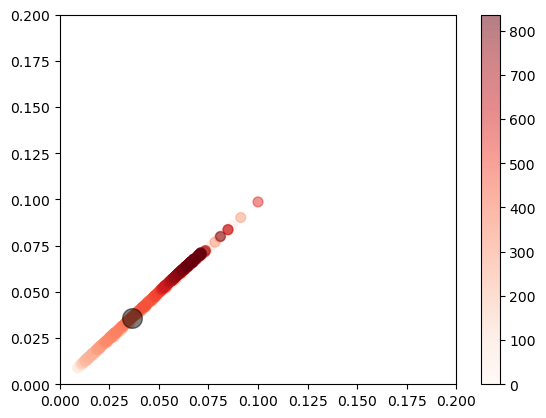

In [53]:
data2 = df2_FC2
p_cluster2 = data2[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster2)



index = np.arange(len(data2))
# p_cluster.shape
plt.scatter(data2['RMS'], data2['Stv'],c= index, cmap='Reds',s=50, alpha=0.5)
plt.colorbar()
centers2 = kmeans.cluster_centers_

plt.scatter(centers2[:, 0], centers2[:, 1], c='black', s=200, alpha=0.5);

plt.xlim(0, .2)
plt.ylim(0, .2)




In [48]:
data2 = df1_FC2

In [49]:

kmeans = KMeans(n_clusters=1)

# Initiate the reference cluster
ref_cluster = data2[0:20]
ref_array = ref_cluster.to_numpy() 
#Find the centroid of this cluster
import numpy as np



reference = kmeans.fit(ref_cluster)
new_cluster = np.empty([0, 2])
centers2 = reference.cluster_centers_
x = data2.iloc[30].values.reshape((1,2))
arr = np.zeros((0,2))  # 定义一个空ndarry数组
arr = np.append(arr, x,axis = 0)
x1 = data2.iloc[31].values.reshape((1,2))
arr = np.append(arr, x1,axis = 0)
print(centers2)

ref_cluster1 = np.append(ref_array,x, axis=0)
ref_cluster1.shape


C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[[0.02454146 0.02453383]]


(21, 2)

In [51]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length
centeroidnp(ref_array)

(0.024541455247163606, 0.024533826880988683)

In [ ]:


from datetime import datetime
n = 0
for i in data.index:
    n = n + 1
    if n == 11:
        print(i)
        break

index_list = []

data1.iloc[21]

In [ ]:
kmeans = KMeans(n_clusters=1)

# Initiate the reference cluster
ref_cluster = data2[0:20]
ref_array = ref_cluster.to_numpy() 
#Find the centroid of this cluster
reference2 = kmeans.fit(ref_cluster)
centers2 = reference.cluster_centers_
print('centroid of the reference cluster is',centers2)
# Initiate the number N
num = 2
# Create an empty array for the anomaly cluster
new_cluster = np.zeros((0,2))
update_list = []
anomaly_list = []

# Input new signals 
for i in range(20, len(data2)):
    x = data2.iloc[i] 
    dist = (np.linalg.norm(x.to_numpy()-centers2))
    x = x.values.reshape((1,2))    
    if dist > 0.15:
        num = num + 1
        new_cluster = np.append(new_cluster,x, axis=0)
        if num >=5:
            #anomaly = kmeans.fit(new_cluster)
            centers_anomaly = centeroidnp(new_cluster)
            print(centers_anomaly)
            anomaly_list.append(centers_anomaly)
        else:
            pass
    else:
        
        ref_cluster = np.append(ref_array,x, axis=0)
        #update = kmeans.fit(ref_cluster)
        center_update = centeroidnp(ref_cluster)
        update_list.append(center_update)



In [ ]:
new_cluster

In [ ]:

length = len(anomaly_list)
anomaly_cluster = np.zeros((length,2))
for i in range(length):
    
    anomaly_cluster[i][0] = anomaly_list[i][0]  
    anomaly_cluster[i][1] = anomaly_list[i][1] 
anomaly_cluster

In [ ]:
length = len(update_list)
update_cluster = np.zeros((length,2))
for i in range(length):
    
    update_cluster[i][0] = update_list[i][0]  
    update_cluster[i][1] = update_list[i][1] 
update_cluster

In [ ]:
anomaly_list
anomaly_cluster = np.zeros((0,2))
for i in anomaly_list:
    anomaly_cluster = np.concatenate((anomaly_cluster,i), axis=0)
# anomaly = pd.DataFrame(a, columns = ['centroid1','centroid2'])
anomaly_cluster.shape
len(anomaly_cluster)
update_cluster = np.zeros((0,2))
for i in update_list:
    update_cluster = np.concatenate((update_cluster,i), axis=0)
update_cluster

In [ ]:

plt.scatter(anomaly_cluster[:,0], anomaly_cluster[:,1],c= range(len(anomaly_cluster)), cmap='YlGn',s=90, alpha=0.5)
plt.colorbar()
# plt.scatter(update_cluster[:,0], update_cluster[:,1],c= range(len(update_cluster)), cmap='Blues',s=90, alpha=0.5)
# plt.colorbar()
plt.scatter(data2['RMS'], data2['Stv'],c= index, cmap='Reds',s=20, alpha=0.5)
plt.colorbar()
plt.scatter(centers2[:, 0], centers2[:, 1], c='black', s=100, alpha=0.5);
plt.scatter(new_cluster[:, 0], new_cluster[:, 1], marker="x", s=10, linewidths=1)
plt.xlim(0, .2)
plt.ylim(0, .2)

In [ ]:

Distance = []
for i in range(21, len(data2)):
    x = data2.iloc[i].to_numpy() 
    dist = (np.linalg.norm(x-centers2))
    Distance.append(dist)
    
plt.plot(Distance)  
plt.ylim(0, .3)



In [ ]:
len(index)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(0.0, 0.2)

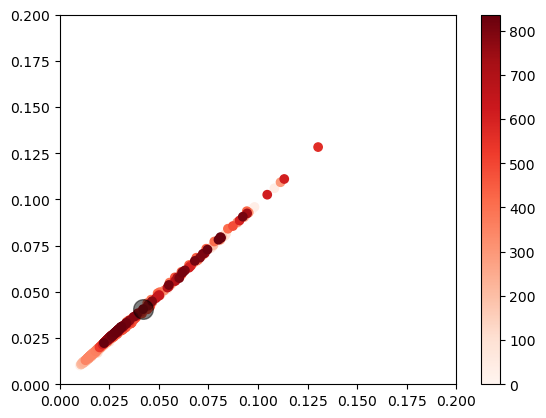

In [54]:
data3 = df3_FC2
p_cluster3 = data3[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster3)

index = np.arange(len(data3))
# p_cluster.shape
plt.scatter(data3['RMS'], data3['Stv'],c= index, cmap='Reds')
plt.colorbar()
centers3 = kmeans.cluster_centers_
plt.scatter(centers3[:, 0], centers3[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .2)
plt.ylim(0, .2)


(0.0, 0.3)

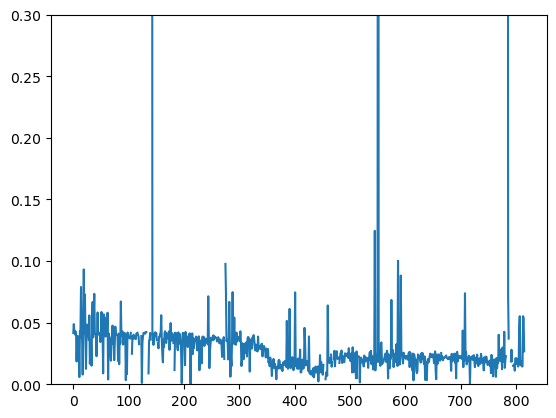

In [65]:
Distance = []
for i in range(21, len(data3)):
    x = data3.iloc[i].to_numpy() 
    dist = (np.linalg.norm(x-centers3))
    Distance.append(dist)
    
plt.plot(Distance)  
plt.ylim(0, .3)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(0.0, 0.2)

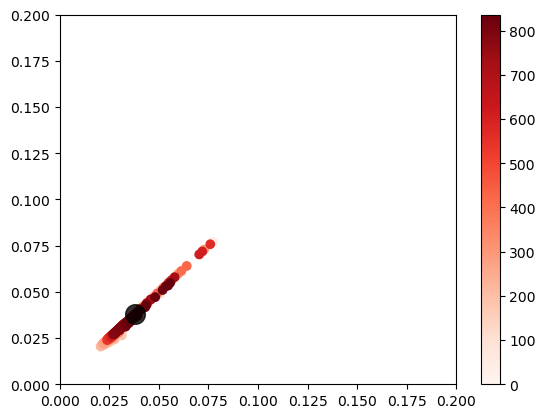

In [56]:
data4 = df4_FC2
p_cluster4 = data4[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster4)



index = np.arange(len(data4))
# p_cluster.shape
plt.scatter(data4['RMS'], data4['Stv'],c= index, cmap='Reds')
plt.colorbar()
centers4 = kmeans.cluster_centers_

plt.scatter(centers4[:, 0], centers4[:, 1], c='black', s=200, alpha=0.8);

plt.xlim(0, .2)
plt.ylim(0, .2)

(0.0, 0.3)

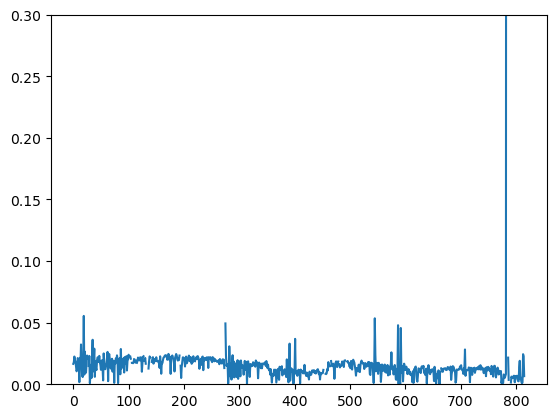

In [68]:
Distance = []
for i in range(21, len(data4)):
    x = data4.iloc[i].to_numpy() 
    dist = (np.linalg.norm(x-centers4))
    Distance.append(dist)
    
plt.plot(Distance)  
plt.ylim(0, .3)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(0.0, 0.2)

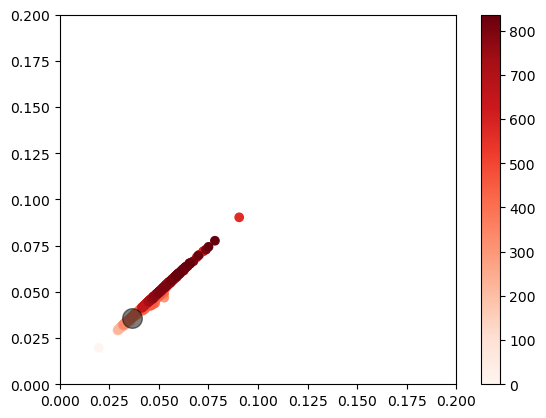

In [82]:
data5 = df5_FC2
p_cluster5 = data5[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster5)


index = np.arange(len(data5))
# p_cluster.shape
plt.scatter(data5['RMS'], data5['Stv'],c= index, cmap='Reds')
plt.colorbar()
centers5 = kmeans.cluster_centers_

plt.scatter(centers5[:, 0], centers5[:, 1], c='black', s=200, alpha=0.5);

plt.xlim(0, .2)
plt.ylim(0, .2)

(0.0, 0.3)

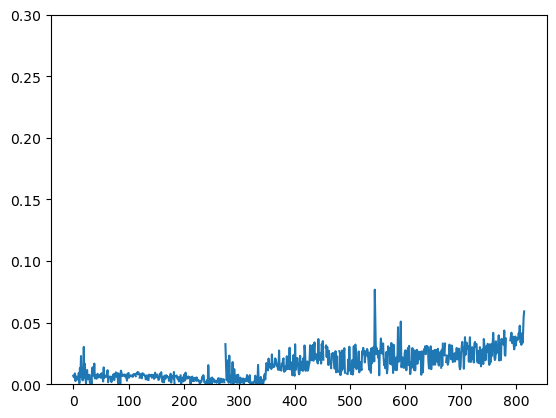

In [84]:
Distance = []
for i in range(21, len(data5)):
    x = data5.iloc[i].to_numpy() 
    dist = (np.linalg.norm(x-centers5))
    Distance.append(dist)
    
plt.plot(Distance)  
plt.ylim(0, .3)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


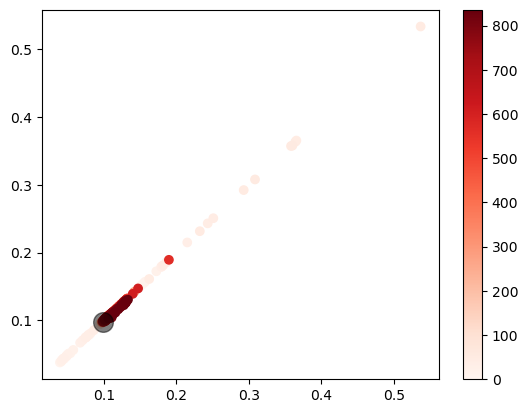

In [79]:
data6 = df6_FC2
p_cluster6 = data6[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster6)


index = np.arange(len(data6))
# p_cluster.shape
plt.scatter(data6['RMS'], data6['Stv'],c= index, cmap='Reds')
plt.colorbar()
centers6 = kmeans.cluster_centers_

plt.scatter(centers6[:, 0], centers6[:, 1], c='black', s=200, alpha=0.5);

# plt.xlim(0, .2)
# plt.ylim(0, .2)

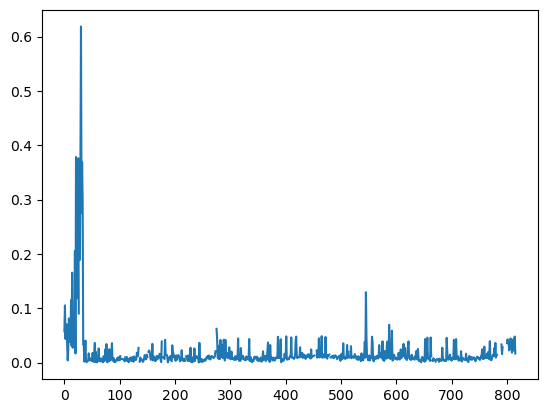

In [80]:
Distance = []
for i in range(21, len(data6)):
    x = data6.iloc[i].to_numpy() 
    dist = (np.linalg.norm(x-centers6))
    Distance.append(dist)
    
plt.plot(Distance)  


In [ ]:
data = df1[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

In [ ]:
data = df2[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .2)
plt.ylim(0, .2)
print(kmeans.labels_)


In [ ]:
data = df3[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

In [ ]:
data = df4[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

In [62]:
data = df5_FC2
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
data = df6[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

In [ ]:
feature = pd.concat([df1[['RMS','Stv']],df2[['RMS','Stv']],df3[['RMS','Stv']],df4[['RMS','Stv']],df5[['RMS','Stv']],df6[['RMS','Stv']]], axis=0)
feature

In [ ]:
pd.set_option('max_colwidth',100)
inertias = []

pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(feature)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(feature)

plt.scatter(feature['RMS'], feature['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)

In [ ]:
import datetime

d = datetime.date(2019, 5, 9)
print(d)
n = 0
df1
df = df1
df  

In [ ]:

df.insert(6, 'Anomaly', value = [True if i < d else False for i in df1.index])
df

In [ ]:
data = df[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)

In [ ]:
File_test = '04-64139_DIAGDATA_20170920_180212__MCC.zip'
feature_list_axis1 = []

from datetime import timedelta
with ZipFile(File_test) as File:
    for file in File.namelist():
        print(file)
        with File.open(file) as f:
            header = read_header(f)
            date = header['date_time']
            print(date.date())
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            plt.figure(figsize=(10,2)) 
            if ax2 in file:
                    # Extract features for axis1
                d = series.normalized_torque()            
                time_index = series.time_index
                   

plt.plot(time_index, d)
plt.show()
plt.hist(d, bins=50)
plt.title('Histogram')
from sklearn.neighbors import KernelDensity




In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
dd = d.reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(dd)
log_dens = kde.score_samples(dd)
ax[1, 1].fill(dd[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")
plt.show()



In [ ]:
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
d1,d2,d3,d4,d5,d6 = [],[],[],[],[],[]
columns=['axis1','axis2','axis3','axis4','axis5','axis6']
divergence_kullbackleibler = pd.DataFrame(columns=columns)
conditional_entropy = pd.DataFrame(columns=columns)
entropy = pd.DataFrame(columns=columns)
mutual_information = pd.DataFrame(columns=columns)
Jensen_Shannon_divergence = pd.DataFrame(columns=columns)
i = 0    
for loop_file in os.listdir(File_path):
    route = os.path.join(File_path,loop_file)
    print(route)
    if '04-64139_DIAGDATA_20170918_135452_3ece932f-a030-4c95-bd2c-e6d899ed8871_MCC.zip' in route:
        ref1,ref2,ref3,ref4,ref5,ref6 = find_reference_point(route)
    else:
        with ZipFile(route) as File:
            for file in File.namelist():
                with File.open(file) as f:
                    header = read_header(f)
                    data = read_data(f)
                    mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                    series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                    if ax1 in file:
                    # Extract features for axis1
                        DATA1 = series.normalized_torque()
                        print(ref1)
                        divergence_kullbackleibler.loc[i, 'axis1'] = drv.entropy_conditional(ref1,DATA1)
                        break
#                         Skewness_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.skewness(d1)
#                         Kurtosis_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d1)
#                         Crest_factor.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d1)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d1)
#                     elif ax2 in file:
#                     # Extract features for axis1
#                         DATA2 = series.torque
#                         d2 = np.concatenate((d2,DATA2), axis=None)
#                         RMS_Value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d2)
#                         Skewness_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.skewness(d2)
#                         Kurtosis_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d2)
#                         Crest_factor.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d2)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d2)
#                     elif ax3 in file:
#                     # Extract features for axis1
#                         DATA3 = series.torque
#                         d3 = np.concatenate((d3,DATA3), axis=None)
#                         RMS_Value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d3)
#                         Skewness_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.skewness(d3)
#                         Kurtosis_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d3)
#                         Crest_factor.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d3)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d3)
#                     elif ax4 in file:
#                     # Extract features for axis1
#                         DATA4 = series.torque
#                         d4 = np.concatenate((d4,DATA4), axis=None)
#                         RMS_Value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d4)
#                         Skewness_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.skewness(d4)
#                         Kurtosis_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d4)
#                         Crest_factor.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d4)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d4)
#                     elif ax5 in file:
#                     # Extract features for axis1
#                         DATA5 = series.torque
#                         d5 = np.concatenate((d5,DATA5), axis=None)
#                         RMS_Value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d5)
#                         Skewness_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.skewness(d5)
#                         Kurtosis_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d5)
#                         Crest_factor.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d5)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d5)
#                     elif ax6 in file:
#                     # Extract features for axis1
#                         DATA6 = series.torque
#                         d6 = np.concatenate((d6,DATA6), axis=None)
#                         RMS_Value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d6)
#                         Skewness_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.skewness(d6)
#                         Kurtosis_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d6)
#                         Crest_factor.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d6)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d6)
#             i = i + 1
               

In [ ]:
A = DATA1-ref1
A

In [ ]:
np.sum(rel_entr(DATA1,ref1))


In [ ]:
plt.figure(figsize=(10,2))
plt.plot(DATA1)
plt.plot(ref1)
# drv.entropy_conditional(ref1, DATA1)

In [ ]:
len(DATA1)